# Итоговый проект: разработка гибридной системы рекомендаций книг с нейросетевыми моделями

---

**Выполнил:** Груданов Николай Алексеевич
**Студнт группы:** М24-525

---

# Наработки дз 1 + исправление замечаний по обратной связи от ментора

## Настройка окружения

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


from surprise import Dataset as SurpriseDataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split

import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torch.cuda.memory as memory

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from surprise.model_selection import train_test_split as surprise_train_test_split
from tqdm import tqdm
import itertools
import os
import sys
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD

import math

In [2]:
# настройка путей

PROJECT_ROOT = Path.cwd()
DATA_DIR = (PROJECT_ROOT / "goodbooks-10k").resolve()
print(f"Текущая рабочая директория: {PROJECT_ROOT}")
print(f"Ожидаемая локальная папка с данными: {DATA_DIR}")

Текущая рабочая директория: /home/gna/workspase/education/MEPHI/MEPHI+SF_ML/academic-semester-3/recommendation systems/session
Ожидаемая локальная папка с данными: /home/gna/workspase/education/MEPHI/MEPHI+SF_ML/academic-semester-3/recommendation systems/session/goodbooks-10k


In [3]:
# Проверка локального наличия датасета Goodbooks-10k
REQUIRED_FILES = ["ratings.csv", "books.csv", "tags.csv", "book_tags.csv"]

missing_files = [fname for fname in REQUIRED_FILES if not (DATA_DIR / fname).exists()]
if missing_files:
    raise FileNotFoundError(
        "Не найдены файлы датасета: " + ", ".join(missing_files) + f". Ожидаем путь {DATA_DIR}"
    )
else:
    for fname in REQUIRED_FILES:
        file_path = DATA_DIR / fname
        size_mb = file_path.stat().st_size / (1024 ** 2)
        print(f"Файл {fname} найден ({size_mb:.2f} MB)")

Файл ratings.csv найден (11.86 MB)
Файл books.csv найден (3.14 MB)
Файл tags.csv найден (0.69 MB)
Файл book_tags.csv найден (15.89 MB)


In [4]:
def check_gpu_environment() -> tuple[str, torch.device, bool]:
    """
    Проверка GPU окружения с красивым форматированным выводом.
    
    Объединяет функциональность проверки доступности CUDA/ROCm,
    определения устройства и вывода детальной информации о GPU.
    
    Returns:
        tuple: (device_str: str, device: torch.device, is_gpu_available: bool)
            - device_str: строковое представление устройства ('cuda' или 'cpu')
            - device: объект torch.device для использования в коде
            - is_gpu_available: флаг доступности GPU (True/False)
    """
    # Импорты (функция самодостаточна)
    import torch
    import torch.cuda.memory as memory
    
    # Разделитель заголовка
    print("\n" + "="*70)
    print("🔍 ПРОВЕРКА GPU ОКРУЖЕНИЯ".center(70))
    print("="*70)
    
    # Базовая информация о PyTorch
    print(f"\n📦 PyTorch версия: {torch.__version__}")
    
    # Проверка доступности CUDA/ROCm
    is_gpu_available = torch.cuda.is_available()
    
    if is_gpu_available:
        # Определение типа GPU (CUDA или ROCm)
        if torch.version.hip:
            gpu_type = "ROCm (AMD)"
            gpu_version = torch.version.hip
            print(f"✅ {gpu_type} обнаружен (версия: {gpu_version})")
        else:
            gpu_type = "CUDA (NVIDIA)"
            gpu_version = torch.version.cuda
            print(f"✅ {gpu_type} обнаружен (версия: {gpu_version})")
        
        # Информация о GPU
        device_count = torch.cuda.device_count()
        print(f"\n📊 Информация о GPU:")
        print(f"   • Количество GPU: {device_count}")
        
        # Детальная информация по каждому GPU
        for i in range(device_count):
            print(f"\n   GPU {i}:")
            print(f"   • Имя: {torch.cuda.get_device_name(i)}")
            total_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3
            print(f"   • Объём VRAM: {total_memory:.2f} GB")
            print(f"   • Вычислительные блоки: {torch.cuda.get_device_properties(i).multi_processor_count}")
        
        # Определение устройства
        device_str = 'cuda'
        device = torch.device('cuda')
        
        # Разделитель
        print("\n" + "="*70)
        print(f"🎯 УСТРОЙСТВО: {device}".center(70))
        print(f"📌 ТИП: {device_str}".center(70))
        print("="*70 + "\n")
        
    else:
        # GPU недоступен
        print(f"⚠️ CUDA/ROCm недоступен")
        print(f"💡 Вычисления будут выполняться на CPU")
        
        # Определение устройства
        device_str = 'cpu'
        device = torch.device('cpu')
        
        # Разделитель
        print("\n" + "="*70)
        print(f"🎯 УСТРОЙСТВО: {device}".center(70))
        print(f"📌 ТИП: {device_str}".center(70))
        print("="*70 + "\n")
    
    return device_str, device, is_gpu_available

In [5]:
check_gpu_environment()



                       🔍 ПРОВЕРКА GPU ОКРУЖЕНИЯ                       

📦 PyTorch версия: 2.5.1+rocm6.2
✅ ROCm (AMD) обнаружен (версия: 6.2.41133-dd7f95766)

📊 Информация о GPU:
   • Количество GPU: 1

   GPU 0:
   • Имя: AMD Radeon RX 7800 XT
   • Объём VRAM: 15.98 GB
   • Вычислительные блоки: 30

                          🎯 УСТРОЙСТВО: cuda                          
                             📌 ТИП: cuda                              



('cuda', device(type='cuda'), True)

---

## EDA

### Изучение даннцых

In [6]:
# Загрузка данных из локальной папки
data_path = DATA_DIR
df_ratings = pd.read_csv(data_path / 'ratings.csv')
df_books = pd.read_csv(data_path / 'books.csv')
df_tags = pd.read_csv(data_path / 'tags.csv')
df_book_tags = pd.read_csv(data_path / 'book_tags.csv')

In [7]:
print("Ratings data:\n")

df_ratings.head()

Ratings data:



,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [8]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [9]:
df_ratings.describe()

,book_id,user_id,rating
count,981756.000000,981756.000000,981756.000000
mean,4943.275636,25616.759933,3.856534
std,2873.207415,15228.338826,0.983941
min,1.000000,1.000000,1.000000
25%,2457.000000,12372.000000,3.000000
50%,4921.000000,25077.000000,4.000000
75%,7414.000000,38572.000000,5.000000
max,10000.000000,53424.000000,5.000000


In [10]:
print(f"Количество уникальных book_id в ratings_df: {df_ratings['book_id'].nunique()}")
print(f"Количество уникальных user_id в ratings_df: {df_ratings['user_id'].nunique()}")
print(f"Количество уникальных значений rating в ratings_df: {df_ratings['rating'].nunique()}")

Количество уникальных book_id в ratings_df: 10000
Количество уникальных user_id в ratings_df: 53424
Количество уникальных значений rating в ratings_df: 5


Из анализа структуры и содержания датафрейма df_ratings следует, что датафрейм содержит оценки, выставленные пользователями для каждой отдельной книни. В датафрейме всего 981 756 записей, пропуски отсутсвуют, все значения имеют числовой тип. Датафрейм содержит оценки для 10 000 уникальных книг, в оценивании приняли участие 53 424 пользоватлей, шкала оценивания от 1 до 5.

In [11]:
print("\nBooks data:")
display(df_books.head())


Books data:


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg


In [12]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

Из анализа структуры и содержания датафрейма df_books следует, что в нем представлены характеристики для каждой книги в отдельности. Всего представлено 10 000 книг, в даафрейм содержит как числовые так и категориальные признаки, имется пропуски в данных в столбцах: isbn, isbn13, original_publication_year,  language_code. Объем пропусков составляет примерно 10% от объема столбца.

In [13]:
print("Tags data:\n")

df_tags.head(30)

Tags data:



,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-
5,5,--166-
6,6,--17-
7,7,--19-
8,8,--2-
9,9,--258-


In [14]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


In [15]:
print(f"Количество уникальных значений tag_name в tags_df: {df_tags['tag_name'].nunique()}")

Количество уникальных значений tag_name в tags_df: 34252


In [16]:
print("\nBook tags data:")
display(df_book_tags.head(10))


Book tags data:


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
5,1,11743,9954
6,1,14017,7169
7,1,5207,6221
8,1,22743,4974
9,1,32989,4364


In [17]:
df_book_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [18]:
print(f"Количество уникальных значений goodreaders в book_tags_df: {df_book_tags['goodreads_book_id'].nunique()}")

Количество уникальных значений goodreaders в book_tags_df: 10000


Из анализа содержания датафрейма df_book_tag следует, что он содержит сведения о количестве меток (тегов) проставленных для конкретной книги в отдельности. Количество goodreads_book_id = 10 000, то есть количеству книг. Сами метки (теги) отражают совершенно различные характеристики книг.
Наиболее часто используемые это: 'to-read', 'fantasy', 'favorites', 'currently-reading', 'young-adult'.

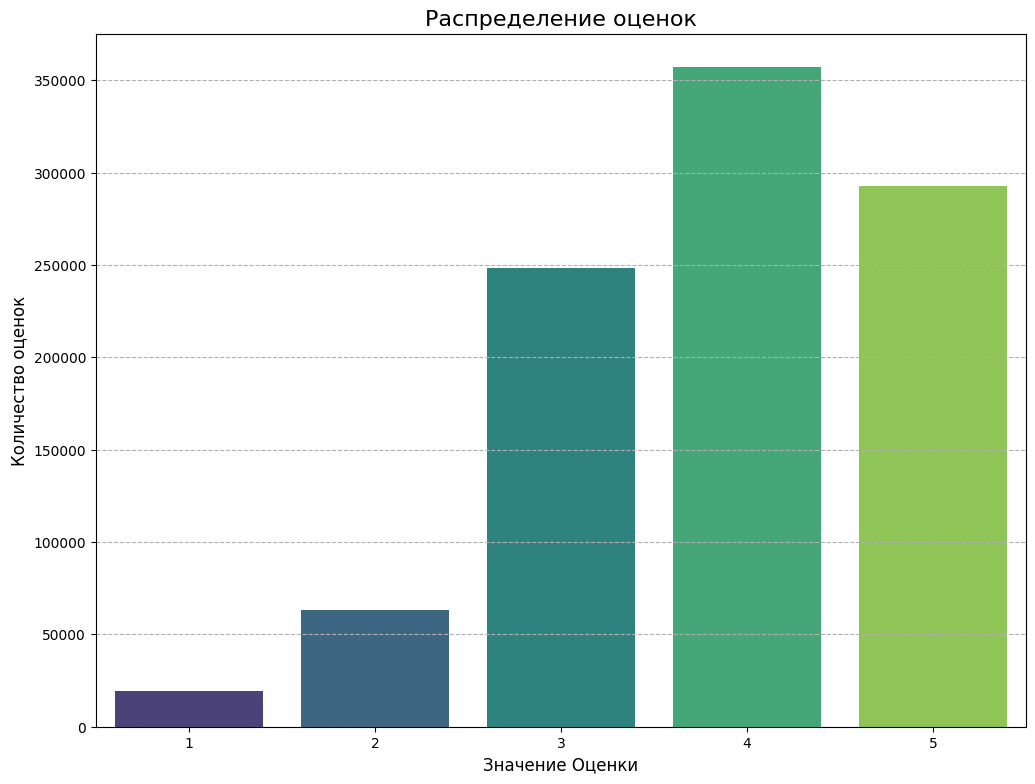

In [19]:
# Определеим как распркеделены оценки
rating_distribution = df_ratings['rating'].value_counts().sort_index()

# Визуализация распределения оценок
plt.figure(figsize=(12, 9))
sns.barplot(x=rating_distribution.index, y=rating_distribution.values, palette='viridis')
plt.title('Распределение оценок', fontsize=16)
plt.xlabel('Значение Оценки', fontsize=12)
plt.ylabel('Количество оценок', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()


Количество уникальных книг, получивших каждую оценку:


,Оценка,Количество уникальных книг
0,5,9999
1,4,10000
2,3,9999
3,2,9679
4,1,7107


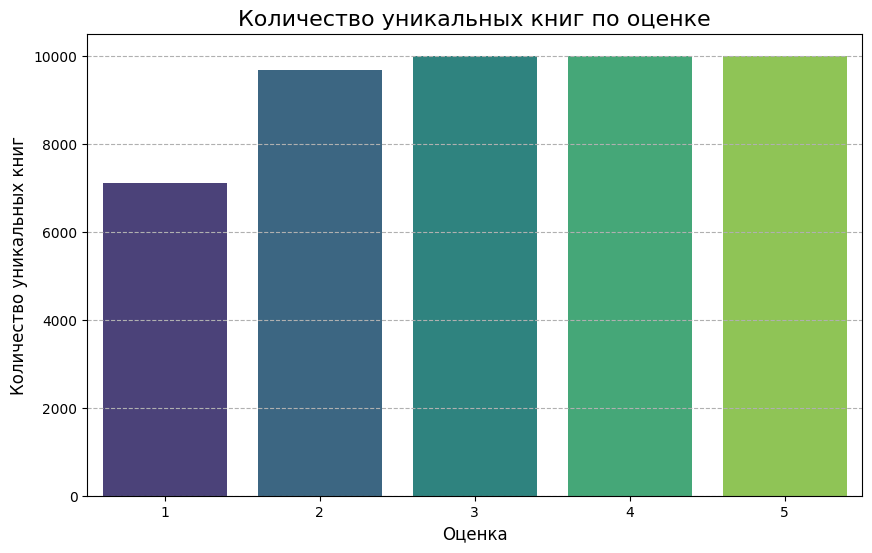

In [20]:
# Получение списка уникальных оценок
unique_ratings = sorted(df_ratings['rating'].unique(), reverse=True)

# Создание словаря для хранения количества книг по каждой оценке
books_per_rating_count = {}

# Проход по каждой уникальной оценке
for rating in unique_ratings:
    # Фильтр по проверяемой оценке
    ratings_for_this_value = df_ratings[df_ratings['rating'] == rating]

    # Подсчет количества уникальных книг в этом отфильтрованном DataFrame
    num_unique_books = ratings_for_this_value['book_id'].nunique()

    # Сохранение результата в словаре
    books_per_rating_count[rating] = num_unique_books

books_per_rating_df = pd.DataFrame(list(books_per_rating_count.items()), columns=['Оценка', 'Количество уникальных книг'])

# Сорптировка по оценке для правильного порядка на графике
books_per_rating_df = books_per_rating_df.sort_values(by='Оценка', ascending=False)


print("\nКоличество уникальных книг, получивших каждую оценку:")
display(books_per_rating_df)

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x='Оценка', y='Количество уникальных книг', data=books_per_rating_df, palette='viridis')
plt.title('Количество уникальных книг по оценке', fontsize=16)
plt.xlabel('Оценка', fontsize=12)
plt.ylabel('Количество уникальных книг', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

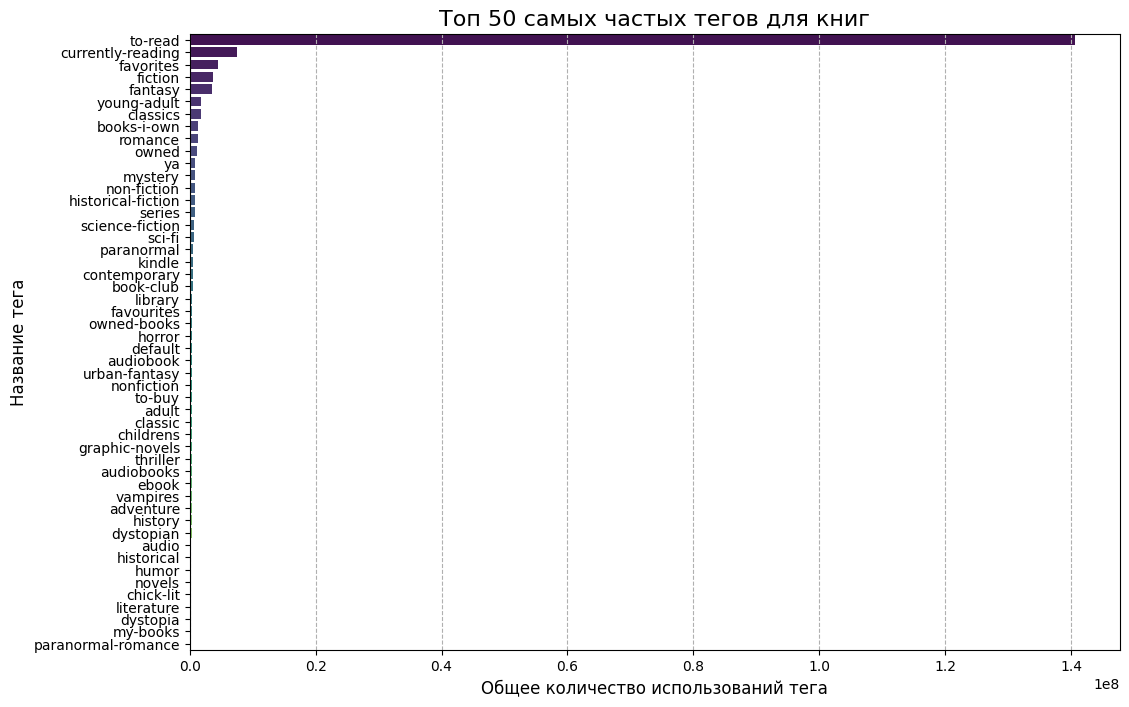


Анализ топ 50 самых частых тегов:


,tag_name,count
30574,to-read,140718761
8717,currently-reading,7507958
11557,favorites,4503173
11743,fiction,3688819
11305,fantasy,3548157
33114,young-adult,1848306
7457,classics,1756920
5207,books-i-own,1317235
26138,romance,1231926
22743,owned,1224279


In [21]:
# Объединение book_tags_df и tags_df для получения названий тегов
book_tags_with_names = pd.merge(df_book_tags, df_tags, on='tag_id')

# Группировка по названию тега и суммирование количества
tag_counts = book_tags_with_names.groupby('tag_name')['count'].sum().reset_index()

# Сортировка по убыванию количества и выбор N самых частых тегов
N = 50 # Количество тегов для визуализации
top_n_tags = tag_counts.sort_values(by='count', ascending=False).head(N)

# Визуализация самых частых тегов
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='tag_name', data=top_n_tags, palette='viridis')
plt.title(f'Топ {N} самых частых тегов для книг', fontsize=16)
plt.xlabel('Общее количество использований тега', fontsize=12)
plt.ylabel('Название тега', fontsize=12)
plt.grid(axis='x', linestyle='--')
plt.show()

# Анализ самых частых тегов
print(f"\nАнализ топ {N} самых частых тегов:")
display(top_n_tags)

Видно что есть перевес в одну сторо6ну. У многих тегов очень малое колисество использований. Это может помешать в обучении модели.

In [22]:
# Анализ основных проблем данных, выявленных на этапе EDA
print("Основные проблемы данных, выявленные на этапе EDA:")

# 1. Разреженность данных
print("\n1. Разреженность данных:")
user_ratings_count = df_ratings['user_id'].value_counts()
print(f"- Общее количество пользователей: {user_ratings_count.count()}")
book_rating_counts = df_ratings['book_id'].value_counts()
print(f"- Общее количество книг: {book_rating_counts.count()}")
print(f"- Общее количество оценок: {len(df_ratings)}")

# Вычисляем потенциальное количество возможных взаимодействий (пользователи * книги)
num_users = user_ratings_count.count()
num_items = book_rating_counts.count()
total_possible_interactions = num_users * num_items

print(f"- Общее возможное количество взаимодействий (пользователь x книга): {total_possible_interactions}")
print(f"- Процент заполненности матрицы взаимодействий: {(len(df_ratings) / total_possible_interactions) * 100:.6f}%")


Основные проблемы данных, выявленные на этапе EDA:

1. Разреженность данных:
- Общее количество пользователей: 53424
- Общее количество книг: 10000
- Общее количество оценок: 981756
- Общее возможное количество взаимодействий (пользователь x книга): 534240000
- Процент заполненности матрицы взаимодействий: 0.183767%


#### **Промежуточные выводы**

1. Статистика датасета:
- Общее количество пользователей: 53424
- Общее количество книг: 10000
- Общее количество оценок: 981756
- Общее возможное количество взаимодействий (пользователь x книга): 534240000
- Процент заполненности матрицы взаимодействий: 0.183767%. Явное свидетельствует об разряженности данных.
2. Распределение оценок явно смещено в сторону оценок 4,5. Подавляющее количество книг имеют именно эти оценики. Важно отметить, что из общего количества пользователей, подавляющее большенство не ставит более 3 оценок. При этом есть явновыдешяющаяся группа пользователей (активное меньшенство), которорые выставлят более 190 оценок для книг. Учитывая, что в датасете всего 10 000 книг, то для полного его покрытия оценками достаточно наличие всего 50 пользователей с уровнем активности в 190 и более оценок. Данная ситуация указывает на то, что основной массив оценок сформирован активным меньгинством, а значит может носить явно выраженный субъективный характер. Построенная модель может при построении рекомендаций будет транслировать субъективное мнение активного меньшенство, что может снизить качество рекомендации.
3. Очевидная проблема холодного старта, при которой большая часть пользователей акттвна при постоновки оценок.
4. Из анализа количества примененных меток (тегов) можно сказать, что наиболее частоиспользуемым является to-read и curently-reading.

Как итог надо сделать манипуляции над данными чтоб с ними можно было работать.


### Работа над данными

Заполним пропуски по столбцу original_title столбцом tittle

In [23]:
df_books ['original_title'] = df_books ['original_title'].fillna(df_books ['title'])

In [24]:
df_books.describe()

,id,book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


In [25]:
df_book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [26]:
df_book_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [27]:
df_tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [28]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


In [29]:
df_tags['tag_name'].unique()

array(['-', '--1-', '--10-', ..., 'Ｍａｎｇａ', 'ＳＥＲＩＥＳ', 'ｆａｖｏｕｒｉｔｅｓ'],
      dtype=object)

Удалит теги которые имеет малое количество использований

In [30]:
df_tags['tag_name'] = df_tags['tag_name'].astype(str).str.lower().str.strip()
df_tags = df_tags[~df_tags['tag_name'].str.contains('owned|favorites|currently-reading|series|books-i-own|to-|default|ebook|audiobook|audio|library|book-club|favourites')]


In [31]:
df_tags.head(25)

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-
5,5,--166-
6,6,--17-
7,7,--19-
8,8,--2-
9,9,--258-


In [32]:
len(df_tags)

31525

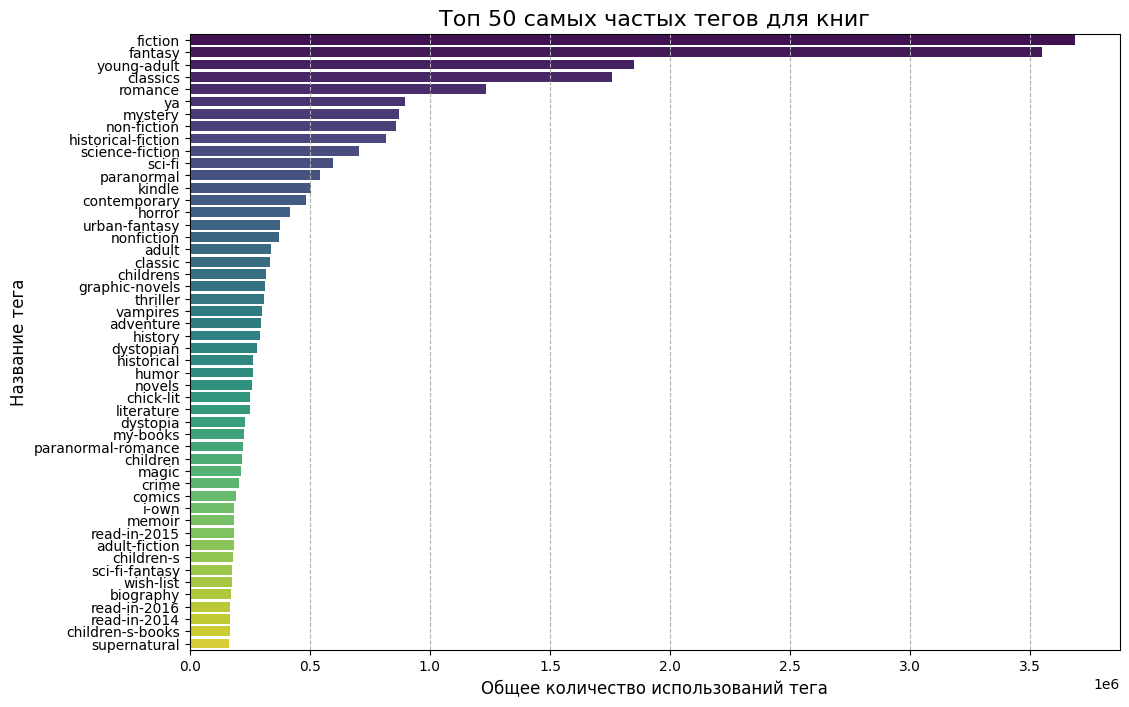


Анализ топ 50 самых частых тегов:


,tag_name,count
10877,fiction,3688819
10476,fantasy,3548157
30397,young-adult,1848306
6857,classics,1756920
24288,romance,1231926
30276,ya,898334
19512,mystery,872282
20202,non-fiction,857901
13485,historical-fiction,815421
24966,science-fiction,703866


In [33]:
# Объединение book_tags_df и tags_df для получения названий тегов
book_tags_with_names = pd.merge(df_book_tags, df_tags, on='tag_id')

# Группировка по названию тега и суммирование количества
tag_counts = book_tags_with_names.groupby('tag_name')['count'].sum().reset_index()

# Сортировка по убыванию количества и выбор N самых частых тегов
N = 50 # Количество тегов для визуализации
top_n_tags = tag_counts.sort_values(by='count', ascending=False).head(N)

# Визуализация самых частых тегов
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='tag_name', data=top_n_tags, palette='viridis')
plt.title(f'Топ {N} самых частых тегов для книг', fontsize=16)
plt.xlabel('Общее количество использований тега', fontsize=12)
plt.ylabel('Название тега', fontsize=12)
plt.grid(axis='x', linestyle='--')
plt.show()

# Анализ самых частых тегов
print(f"\nАнализ топ {N} самых частых тегов:")
display(top_n_tags)

Удалим теги которые содержат не валидные смиволы, цифры и другой шум

In [34]:
df_tags['tag_name'] = df_tags['tag_name'].astype(str).str.lower().str.strip()
df_tags = df_tags[~df_tags['tag_name'].str.contains(r'[0-9+()\[\]\\?/_. ,=]')]
df_tags = df_tags[df_tags['tag_name'].str.match(r'^[a-zA-Z\s\-]+$')]
df_tags = df_tags[~df_tags['tag_name'].str.match(r'^[-]')]
df_tags = df_tags[~df_tags['tag_name'].str.match(r'[-]$')]
tadf_tagsgs = df_tags[df_tags['tag_name'].isin(df_book_tags.merge(df_tags, on='tag_id', how='inner').groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)['tag_name'].head(10000))]

In [35]:
df_tags.head(25)

,tag_id,tag_name
1291,1291,a
1293,1293,a-a-fiction
1294,1294,a-a-milne
1295,1295,a-amsterdam
1296,1296,a-bad-case-of-stripes
1297,1297,a-baker-s-education
1298,1298,a-beautiful-dark
1303,1303,a-child-called-it
1304,1304,a-christie
1305,1305,a-corner-of-the-universe


In [36]:
len(df_tags)

27773

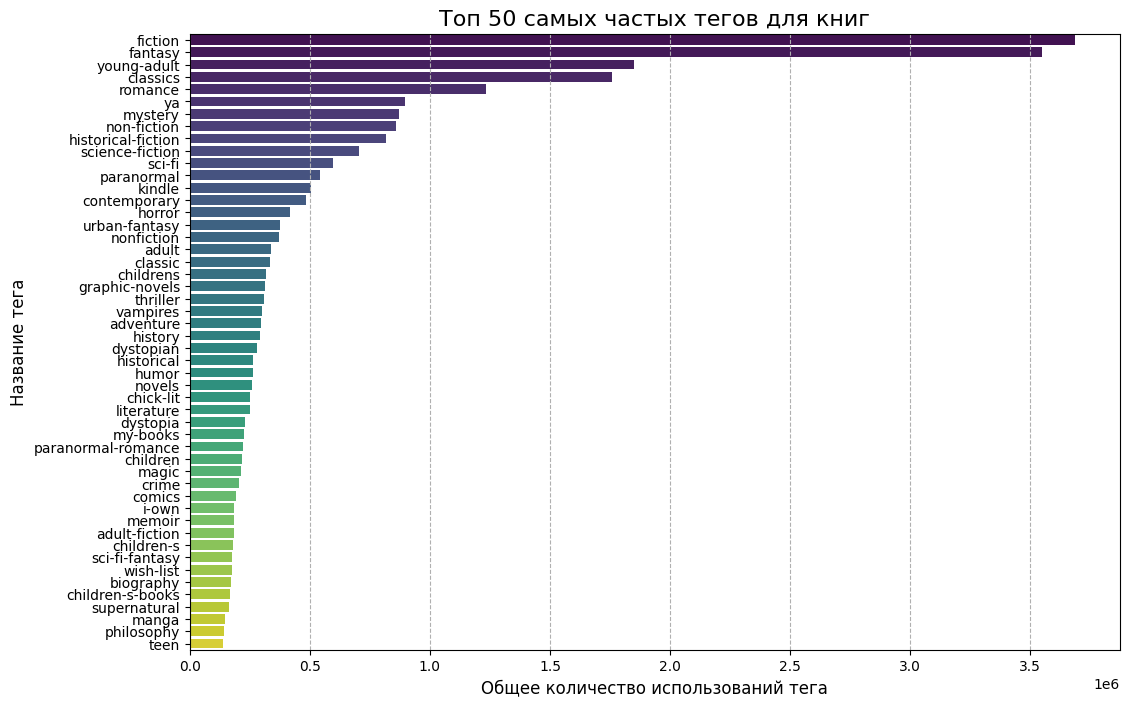


Анализ топ 50 самых частых тегов:


,tag_name,count
9141,fiction,3688819
8759,fantasy,3548157
27620,young-adult,1848306
5295,classics,1756920
21821,romance,1231926
27512,ya,898334
17371,mystery,872282
18037,non-fiction,857901
11644,historical-fiction,815421
22475,science-fiction,703866


In [37]:
# Объединение book_tags_df и tags_df для получения названий тегов
book_tags_with_names = pd.merge(df_book_tags, df_tags, on='tag_id')

# Группировка по названию тега и суммирование количества
tag_counts = book_tags_with_names.groupby('tag_name')['count'].sum().reset_index()

# Сортировка по убыванию количества и выбор N самых частых тегов
N = 50 # Количество тегов для визуализации
top_n_tags = tag_counts.sort_values(by='count', ascending=False).head(N)

# Визуализация самых частых тегов
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='tag_name', data=top_n_tags, palette='viridis')
plt.title(f'Топ {N} самых частых тегов для книг', fontsize=16)
plt.xlabel('Общее количество использований тега', fontsize=12)
plt.ylabel('Название тега', fontsize=12)
plt.grid(axis='x', linestyle='--')
plt.show()

# Анализ самых частых тегов
print(f"\nАнализ топ {N} самых частых тегов:")
display(top_n_tags)

In [38]:
df_tags.head(25)

,tag_id,tag_name
1291,1291,a
1293,1293,a-a-fiction
1294,1294,a-a-milne
1295,1295,a-amsterdam
1296,1296,a-bad-case-of-stripes
1297,1297,a-baker-s-education
1298,1298,a-beautiful-dark
1303,1303,a-child-called-it
1304,1304,a-christie
1305,1305,a-corner-of-the-universe


In [39]:
df_tags.tail(25)

,tag_id,tag_name
33266,33266,zombie-horror
33267,33267,zombie-novels
33268,33268,zombies
33269,33269,zombies-and-such
33270,33270,zone
33271,33271,zones-of-thought
33272,33272,zoo
33273,33273,zoo-animals
33274,33274,zooey
33275,33275,zoology


In [40]:
len(df_tags)

27773

Сейчас мы видим среди самых частых тегов встречаются не только жанровые и тематические метки (`fiction`, `fantasy`, `young-adult` и т.п.), но и теги, отражающие статус чтения или формат книги:  `books-i-own`, `owned`, `wish-list`, `kindle`.  Нам не нужнен татус чтения или личные списки пользователей или теги устройств, нас в первую очередь интересуют жанры. Поэтому попробуем ухбрать эти теги. 

In [41]:
df_tags["tag_name"] = (
    df_tags["tag_name"]
    .astype(str)
    .str.lower()
    .str.strip()
)

In [42]:
def show_tags_by_substring(substr, n=50):
    """
    Ищет теги, содержащие подстроку substr,
    и показывает топ-n по суммарному использованию (count из df_book_tags).
    """
    mask = df_tags["tag_name"].str.contains(substr, case=False, na=False)
    tags_sub = df_tags[mask].copy()
    if tags_sub.empty:
        print(f"Тегов с подстрокой '{substr}' не найдено.")
        return
    
    usage = (
        df_book_tags
        .merge(tags_sub[["tag_id", "tag_name"]], on="tag_id", how="inner")
        .groupby("tag_name")["count"]
        .sum()
        .reset_index()
        .sort_values("count", ascending=False)
        .head(n)
    )
    
    print(f"Теги, содержащие '{substr}', и их суммарное использование:")
    display(usage)


In [43]:
show_tags_by_substring("read")

Теги, содержащие 'read', и их суммарное использование:


,tag_name,count
567,re-read,135680
652,read-for-school,47552
877,reread,44294
677,read-in-english,43608
892,rory-gilmore-reading-challenge,36032
454,must-read,32911
735,read-more-than-once,16629
137,childhood-reads,15938
994,unread,12605
578,read-aloud,12374


In [44]:
show_tags_by_substring("own")

Теги, содержащие 'own', и их суммарное использование:


,tag_name,count
77,i-own,184735
157,own-it,108605
51,dan-brown,9719
82,i-own-it,2875
224,sandra-brown,2757
60,downloaded,2091
162,own-kindle,1485
229,small-town,1472
21,books-we-own,920
27,brown-dan,759


In [45]:
show_tags_by_substring("wish")

Теги, содержащие 'wish', и их суммарное использование:


,tag_name,count
33,wish-list,175729
30,shelfari-wishlist,5676
11,jewish,4851
14,jewish-fiction,130
19,jewish-literature,97
18,jewish-lit,44
24,jewish-themes,41
35,wish-wish,38
15,jewish-history,29
26,manga-wishlist,11


In [46]:
show_tags_by_substring("pocketbook")

Тегов с подстрокой 'pocketbook' не найдено.


In [47]:
show_tags_by_substring("onyxboox")

Тегов с подстрокой 'onyxboox' не найдено.


In [48]:
show_tags_by_substring("kindle")

Теги, содержащие 'kindle', и их суммарное использование:


,tag_name,count
16,kindle,506882
19,kindle-books,25532
66,on-kindle,13674
49,kindle-unlimited,8092
67,on-my-kindle,5191
29,kindle-first,1979
71,own-kindle,1485
36,kindle-freebie,907
37,kindle-freebies,627
18,kindle-book,450


In [49]:
show_tags_by_substring("ebook")

Тегов с подстрокой 'ebook' не найдено.


In [50]:
show_tags_by_substring("audio")

Тегов с подстрокой 'audio' не найдено.


In [51]:
show_tags_by_substring("club")

Теги, содержащие 'club', и их суммарное использование:


,tag_name,count
8,bookclub,68562
64,women-s-murder-club,2578
65,womens-murder-club,1218
38,motorcycle-club,1174
7,book-of-the-month-club,810
30,james-patterson-women-s-murder-club,357
39,motorcycle-clubs,269
15,camel-club,269
35,mc-club,236
10,bookclub-books,162


In [52]:
show_tags_by_substring("my-")

Теги, содержащие 'my-', и их суммарное использование:


,tag_name,count
75,my-books,225606
187,on-my-shelf,36175
77,my-bookshelf,20903
179,on-my-bookshelf,8961
81,my-childhood,7107
180,on-my-kindle,5191
20,books-from-my-childhood,4073
89,my-collection,1832
42,from-my-childhood,1542
159,my-shelf,981


In [53]:
show_tags_by_substring("read-in-")

Теги, содержащие 'read-in-', и их суммарное использование:


,tag_name,count
13,read-in-english,43608
35,read-in-school,8245
17,read-in-high-school,2351
16,read-in-german,1161
15,read-in-french,1005
39,read-in-spanish,422
34,read-in-russian,386
7,read-in-college,129
40,read-in-swedish,118
29,read-in-polish,115


Перед тем, как удалять статусные и служебные теги (отражающие не содержание книги, а статус чтения или формат носителя), мы сначала явно их обнаружили в данных. Теперь составим из них словарь и почистим наши данные


In [54]:
status_tags = {
    # ---------- read / reads / reading ----------
    "re-read",
    "read-for-school",
    "reread",
    "read-in-english",
    "rory-gilmore-reading-challenge",
    "must-read",
    "read-more-than-once",
    "childhood-reads",
    "unread",
    "read-aloud",
    "first-reads",
    "school-reads",
    "re-reads",
    "rory-gilmore-reading-list",
    "read-as-a-kid",
    "read-in-school",
    "school-reading",
    "read-alouds",
    "required-reading",
    "summer-reads",
    "read-as-a-child",
    "summer-reading",
    "bbc-big-read",
    "beach-reads",
    "read-again",
    "comics-read",
    "stopped-reading",
    "read-comics",
    "already-read",
    "manga-read",
    "partially-read",
    "read-manga",
    "rereads",
    "young-readers",
    "read-fantasy",
    "read-in-high-school",
    "books-i-read-as-a-kid",
    "gilmore-girls-reading-list",
    "fantasy-read",
    "maybe-read",
    "read-fiction",
    "not-read",
    "graphic-novels-read",
    "re-reading",
    "have-read",
    "classics-read",
    "read-with-kids",
    "read-in-german",
    "the-rory-gilmore-reading-challenge",
    "assigned-reading",

    # ---------- own / i-own / владение ----------
    "i-own",
    "own-it",
    "i-own-it",
    "downloaded",
    "own-kindle",
    "books-we-own",
    "own-a-copy",
    "manga-i-own",
    "own-on-kindle",
    "own-tbr",
    "own-not-read",
    "own-read",
    "do-not-own",
    "own-but-not-read",
    "already-own",
    "own-book",
    "book-i-own",
    "comics-i-own",
    "own-unread",
    "i-own-a-copy",
    "currently-own",
    "own-but-haven-t-read",
    "i-own-this",
    "books-that-i-own",
    "own-paperback",
    "don-t-own",
    "own-books",
    "own-and-read",
    "own-hard-copy",

    # ---------- my-* / личные полки и коллекции ----------
    "my-books",
    "on-my-shelf",
    "my-bookshelf",
    "on-my-bookshelf",
    "my-childhood",
    "on-my-kindle",
    "books-from-my-childhood",
    "my-collection",
    "from-my-childhood",
    "my-shelf",
    "my-favs",
    "my-manga",
    "my-blood-approves",
    "my-favorite-books",
    "my-cookbooks",
    "my-kindle-books",
    "on-my-shelves",
    "my-book",
    "my-fav",
    "my-favorite",
    "my-book-shelf",
    "my-childhood-books",
    "mommy-books",
    "books-of-my-childhood",
    "my-collections",
    "my-reads",
    "my-own",
    "my-graphic-novels",
    "my-faves",
    "books-on-my-shelf",
    "in-my-bookshelf",
    "my-favourite",
    "my-favorite-mistake",
    "in-my-collection",
    "all-my-books",

    # ---------- wishlist / wish / wish-list ----------
    "wish-list",
    "shelfari-wishlist",
    "manga-wishlist",
    "wish",
    "wish-wish",
    "cookbook-wishlist",
    "my-wishlist",
    "twenty-wishes",
    "wishbone",
    "wishes",
    "wishntref",
    "wishlist-nonfiction",
    "wish-list-needed-vintage-paperbacks",
    "wishlist-manga",
    "cookbooks-wishlist",
    "book-wishlist",
    "wishlist-indonesian",
    "kindle-wishlist",
    "historical-fiction-wishlist",
    "indonesia-fict-wishlist",
    "christmas-wish-read-list",
    "british-isles-wish",
    "contemporary-wish-list",
    "any-wish-list",
    "photography-wishlist",
    "my-book-wish",
    "wishlist-eventually",
    "wishlist-art-history-etc",
    "wishlist-eng",
    "wishlist-non-fiction",
    "wishlist-new",
    "wishlist-short-stories-poetry",
    "wishlist-vampyre-history-and-lit",

    # ---------- bookclub / club (читающие клубы) ----------
    "bookclub",
    "book-of-the-month-club",
    "bookclub-books",
    "oprah-s-bookclub",
    "oprahs-bookclub",
    "oprah-bookclub",
    "oprahbookclub",
    "botm-club",
    "vaginal-fantasy-bookclub",
    "sunday-philosophy-club",
    "emma-watson-bookclub",
    "bookclub-reads",
    "rwbookclub",
    "bookclub-book",
    "clublecturems",
    "club-lecture-ms",
    "twookclub",
    "target-club-picks",
    "leesclub",
    "monkton-bookclub",

    # ---------- kindle ----------
    "kindle",
    "kindle-books",
    "on-kindle",
    "kindle-unlimited",
    "on-my-kindle",
    "kindle-first",
    "own-kindle",
    "kindle-freebie",
    "kindle-freebies",
    "kindle-store",
    "kindle-store-books",
    "kindle-store-books-2015",
    "kindle-store-books-2016",
    "kindle-store-books-2017",
    "kindle-book",
    "own-on-kindle",
    "kindle-lendable",
    "kindle-read",
    "kindle-free",
    "free-kindle-books",
    "my-kindle-books",
    "free-kindle",
    "kindle-tbr",
    "read-on-kindle",
    "kindleunlimited",
    "books-on-kindle",
    "kindle-own",
    "books-on-kindle",
    "my-kindle",
    "books-on-my-kindle",
    "a-kindle",
    "no-kindle-version",
}


In [55]:
df_tags_clean = df_tags[~df_tags["tag_name"].isin(status_tags)].copy()

valid_tag_ids = set(df_tags_clean["tag_id"].unique())
df_book_tags_clean = df_book_tags[df_book_tags["tag_id"].isin(valid_tag_ids)].copy()

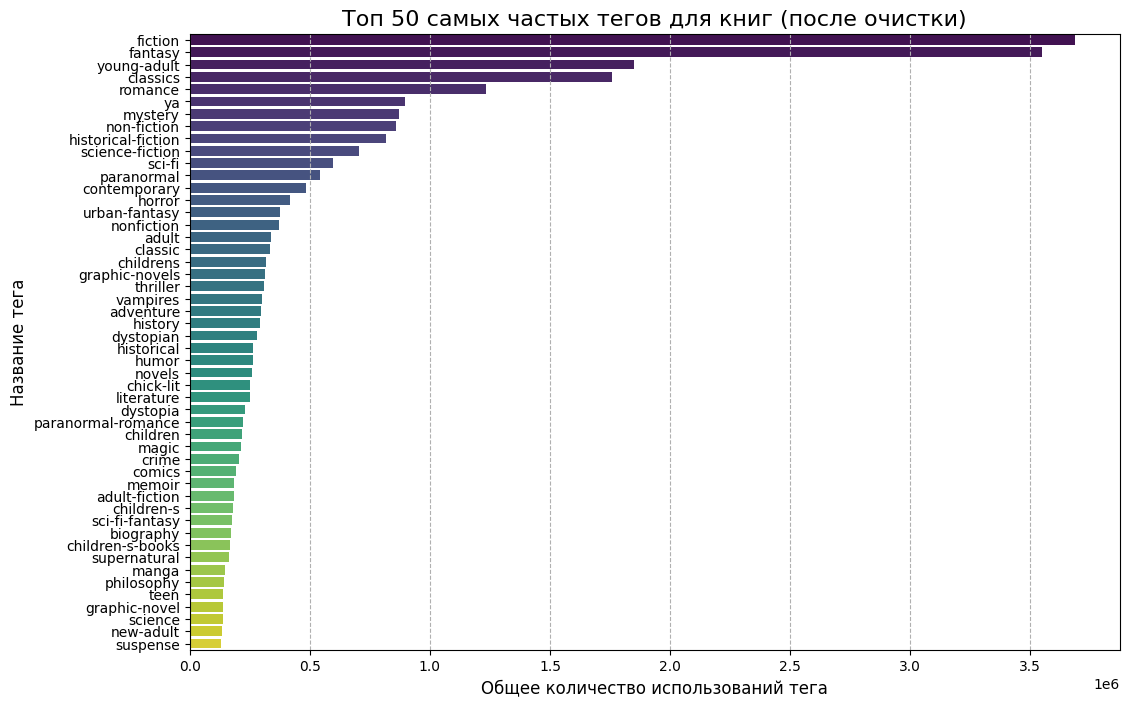


Анализ топ 50 самых частых тегов (после очистки):


,tag_name,count
9100,fiction,3688819
8719,fantasy,3548157
27432,young-adult,1848306
5268,classics,1756920
21666,romance,1231926
27324,ya,898334
17267,mystery,872282
17932,non-fiction,857901
11596,historical-fiction,815421
22315,science-fiction,703866


In [56]:
# Объединение очищенных df_book_tags_clean и df_tags_clean для получения названий тегов
book_tags_clean_with_names = pd.merge(
    df_book_tags_clean,
    df_tags_clean,
    on="tag_id"
)

# Группировка по названию тега и суммирование количества
tag_counts_clean = (
    book_tags_clean_with_names
    .groupby("tag_name")["count"]
    .sum()
    .reset_index()
)

# Сортировка по убыванию количества и выбор N самых частых тегов
N = 50  # Количество тегов для визуализации
top_n_tags_clean = (
    tag_counts_clean
    .sort_values(by="count", ascending=False)
    .head(N)
)

# Визуализация самых частых тегов (после очистки от статусных тегов)
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="tag_name", data=top_n_tags_clean, palette="viridis")
plt.title(f"Топ {N} самых частых тегов для книг (после очистки)", fontsize=16)
plt.xlabel("Общее количество использований тега", fontsize=12)
plt.ylabel("Название тега", fontsize=12)
plt.grid(axis="x", linestyle="--")
plt.show()

# Анализ самых частых тегов
print(f"\nАнализ топ {N} самых частых тегов (после очистки):")
display(top_n_tags_clean)


Видем что в топе тегов есть ондни и теже жанры но с разным написанием. Попробуем их смаппить чтоб не было шума

In [57]:
tag_aliases = {
    "sci-fi": "science-fiction",
    "ya": "young-adult",
    "nonfiction": "non-fiction",
    "classic": "classics",
    "childrens": "children",
    "children-s": "children",
    "children-s-books": "children",
    "dystopia": "dystopian", 
}

def normalize_tag_name(name: str) -> str:
    name = str(name).strip().lower()
    return tag_aliases.get(name, name)

df_tags_clean["tag_name"] = df_tags_clean["tag_name"].apply(normalize_tag_name)

df_tags_clean["tag_name"].value_counts()

tag_name
children           4
dystopian          2
science-fiction    2
non-fiction        2
young-adult        2
                  ..
fiction-ya         1
fiction-wwii       1
fiction-world      1
fiction-western    1
fictious           1
Name: count, Length: 27576, dtype: int64

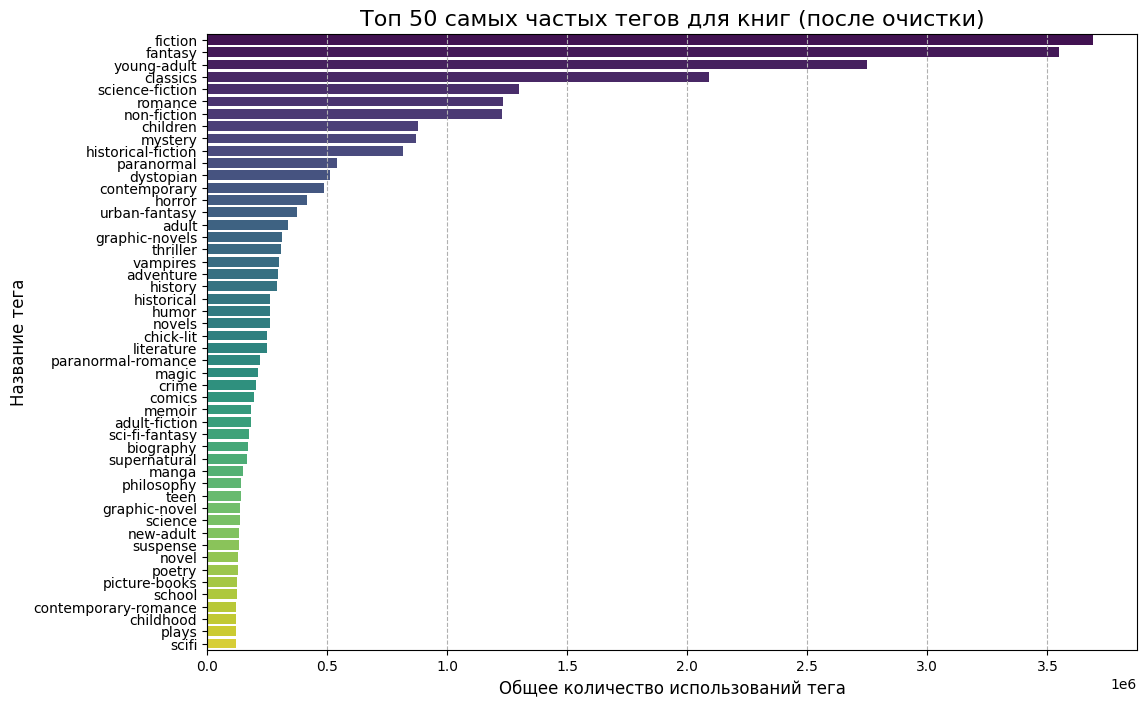


Анализ топ 50 самых частых тегов (после очистки):


,tag_name,count
9095,fiction,3688819
8714,fantasy,3548157
27424,young-adult,2746640
5264,classics,2091033
22308,science-fiction,1301191
21660,romance,1231926
17927,non-fiction,1228950
4726,children,880012
17262,mystery,872282
11591,historical-fiction,815421


In [58]:
# Объединение очищенных df_book_tags_clean и df_tags_clean для получения названий тегов
book_tags_clean_with_names = pd.merge(
    df_book_tags_clean,
    df_tags_clean,
    on="tag_id"
)

# Группировка по названию тега и суммирование количества
tag_counts_clean = (
    book_tags_clean_with_names
    .groupby("tag_name")["count"]
    .sum()
    .reset_index()
)

# Сортировка по убыванию количества и выбор N самых частых тегов
N = 50  # Количество тегов для визуализации
top_n_tags_clean = (
    tag_counts_clean
    .sort_values(by="count", ascending=False)
    .head(N)
)

# Визуализация самых частых тегов (после очистки от статусных тегов)
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="tag_name", data=top_n_tags_clean, palette="viridis")
plt.title(f"Топ {N} самых частых тегов для книг (после очистки)", fontsize=16)
plt.xlabel("Общее количество использований тега", fontsize=12)
plt.ylabel("Название тега", fontsize=12)
plt.grid(axis="x", linestyle="--")
plt.show()

# Анализ самых частых тегов
print(f"\nАнализ топ {N} самых частых тегов (после очистки):")
display(top_n_tags_clean)

In [59]:
tag_counts_clean[tag_counts_clean["tag_name"].isin(
    ["sci-fi", "scifi", "science-fiction"]
)].sort_values("tag_name")


,tag_name,count
22308,science-fiction,1301191
22361,scifi,119566


In [60]:
tag_aliases = {
    "scifi": "science-fiction"
}

def normalize_tag_name(name: str) -> str:
    name = str(name).strip().lower()
    return tag_aliases.get(name, name)

df_tags_clean["tag_name"] = df_tags_clean["tag_name"].apply(normalize_tag_name)


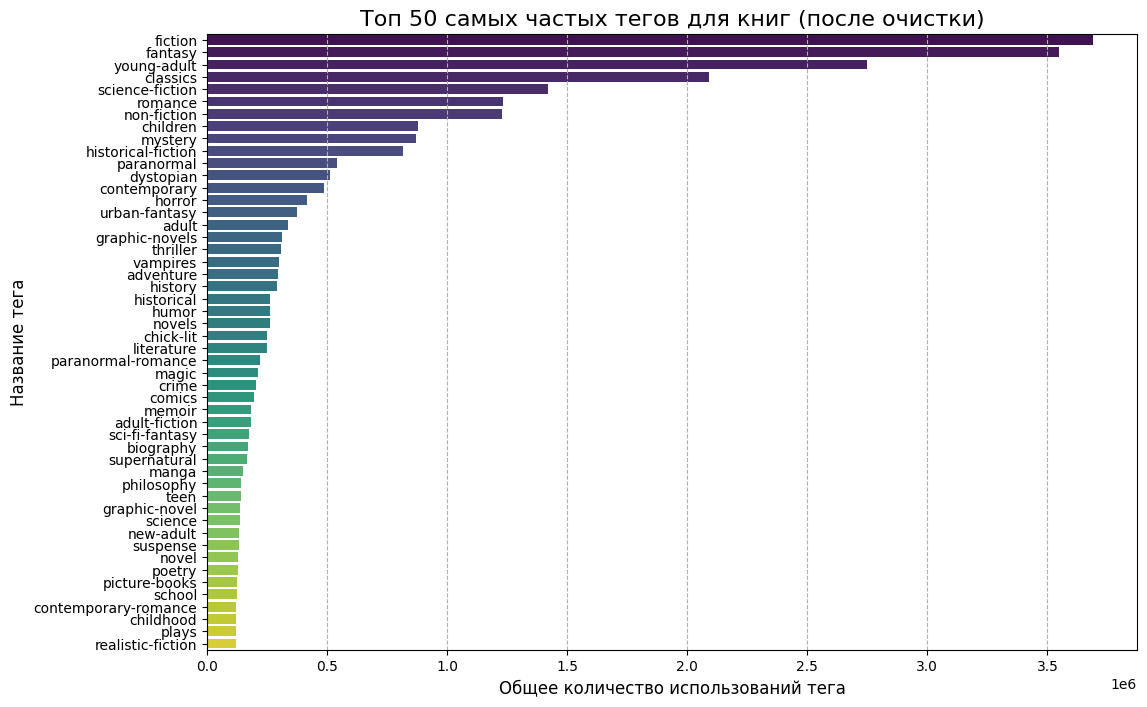


Анализ топ 50 самых частых тегов (после очистки):


,tag_name,count
9095,fiction,3688819
8714,fantasy,3548157
27423,young-adult,2746640
5264,classics,2091033
22308,science-fiction,1420757
21660,romance,1231926
17927,non-fiction,1228950
4726,children,880012
17262,mystery,872282
11591,historical-fiction,815421


In [61]:
# Объединение очищенных df_book_tags_clean и df_tags_clean для получения названий тегов
book_tags_clean_with_names = pd.merge(
    df_book_tags_clean,
    df_tags_clean,
    on="tag_id"
)

# Группировка по названию тега и суммирование количества
tag_counts_clean = (
    book_tags_clean_with_names
    .groupby("tag_name")["count"]
    .sum()
    .reset_index()
)

# Сортировка по убыванию количества и выбор N самых частых тегов
N = 50  # Количество тегов для визуализации
top_n_tags_clean = (
    tag_counts_clean
    .sort_values(by="count", ascending=False)
    .head(N)
)

# Визуализация самых частых тегов (после очистки от статусных тегов)
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="tag_name", data=top_n_tags_clean, palette="viridis")
plt.title(f"Топ {N} самых частых тегов для книг (после очистки)", fontsize=16)
plt.xlabel("Общее количество использований тега", fontsize=12)
plt.ylabel("Название тега", fontsize=12)
plt.grid(axis="x", linestyle="--")
plt.show()

# Анализ самых частых тегов
print(f"\nАнализ топ {N} самых частых тегов (после очистки):")
display(top_n_tags_clean)

In [62]:
tag_counts_clean[tag_counts_clean["tag_name"].isin(
    ["historical-fiction", "history", "historical"]
)].sort_values("tag_name")

,tag_name,count
11571,historical,263267
11591,historical-fiction,815421
11650,history,291366


В ходе анализа тегов было решено **не объединять** теги `history` и `historical`, поскольку они отражают различные типы содержаний. Тег `history` преимущественно маркирует нон‑фикшн по истории (исследования, биографии, популярная история), тогда как `historical` используется как более общий признак «исторического контекста» и часто сочетается с художественными жанрами (например, historical fiction). Объединение этих тегов привело бы к смешению документальной литературы и художественных произведений с историческим фоном, что ухудшило бы интерпретируемость и точность контентных признаков. 

#### Вывод

Мы смогли очистить наши данные от шума в виде мусорных тегов. Убрали то что состояло из символов и цифр, убрали служебные теги по типу "проситать позже", "людимое", "для школы", "электроная книга". Также слили некоторые жанры в один.

## Модели

#### Неперсонализированная модель

In [63]:
data_path = DATA_DIR

df_ratings_raw = pd.read_csv(data_path / "ratings.csv")
df_books_raw   = pd.read_csv(data_path / "books.csv")

print(len(df_ratings_raw), df_ratings_raw["book_id"].nunique())


981756 10000


In [64]:
book_stats_raw = (
    df_ratings_raw
    .groupby("book_id")["rating"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "mean_rating", "count": "n_ratings"})
)

def get_top_n_popularity_raw(N=10, min_count=20):
    top = (
        book_stats_raw[book_stats_raw["n_ratings"] >= min_count]
        .sort_values("mean_rating", ascending=False)
        .head(N)
    )
    top = top.merge(
        df_books_raw[["book_id", "original_title", "title", "authors", "ratings_count"]],
        on="book_id",
        how="left"
    )
    top["original_title"] = top["original_title"].fillna(top["title"])
    return top

display(get_top_n_popularity_raw(10, min_count=20))


,book_id,mean_rating,n_ratings,original_title,title,authors,ratings_count
0,7947,4.820225,89,NaN,NaN,NaN,NaN
1,6920,4.780000,100,NaN,NaN,NaN,NaN
2,5207,4.780000,100,NaN,NaN,NaN,NaN
3,9566,4.777778,99,Still Life with Woodpecker,Still Life with Woodpecker,Tom Robbins,56802.0
4,8946,4.774194,93,NaN,NaN,NaN,NaN
5,3275,4.770000,100,NaN,NaN,NaN,NaN
6,6361,4.770000,100,NaN,NaN,NaN,NaN
7,4483,4.750000,100,NaN,NaN,NaN,NaN
8,5580,4.750000,100,NaN,NaN,NaN,NaN
9,6590,4.750000,100,NaN,NaN,NaN,NaN


### Контентная модель

In [65]:
# 1. Маппинг между внутренним ID и goodreads_book_id
# id — внутренний (1..10000, как в ratings.book_id)
# book_id — goodreads_book_id (большие числа)
bookid_map = df_books[["id", "book_id"]].rename(
    columns={
        "id": "book_id_internal",        # внутренний ID
        "book_id": "goodreads_book_id"   # внешний ID из Goodreads
    }
)

# 2. Объединяем очистенный book_tags с маппингом и тегами
book_with_tags_clean = (
    df_book_tags_clean
    .merge(bookid_map, on="goodreads_book_id", how="inner")
    .merge(df_tags_clean[["tag_id", "tag_name"]], on="tag_id", how="inner")
)

print(book_with_tags_clean.columns)


Index(['goodreads_book_id', 'tag_id', 'count', 'book_id_internal', 'tag_name'], dtype='object')


In [66]:
book_tags_grouped = (
    book_with_tags_clean
    .groupby("book_id_internal")["tag_name"]
    .apply(lambda tags: " ".join(sorted(set(tags))))
    .reset_index()
    .rename(columns={"tag_name": "tag_profile"})
)

display(book_tags_grouped.head())


,book_id_internal,tag_profile
0,1,action action-adventure adventure books borrowed coming-of-age contemporary distopia distopian drama dystopian dystopian-fiction dystopias e-book english fantasy fantasy-sci-fi faves favorite favorite-books favourite favourite-books favs fiction finished future futuristic hunger-games love love-triangle loved novel novels post-apocalyptic reviewed romance sci-fi-fantasy science-fiction scifi-fantasy sf speculative-fiction survival suspense suzanne-collins teen teen-fiction the-hunger-games thriller trilogy ya-books ya-dystopian ya-fantasy ya-fiction ya-lit young-adult young-adult-fiction
1,2,adventure books bookshelf british childhood childhood-books children children-s-lit children-s-literature childrens-books classics contemporary england english fantasy fantasy-sci-fi faves favorite favorite-books favourite favourite-books favs fiction friendship harry-potter j-k-rowling jk-rowling juvenile kids kids-books magic middle-grade mystery novel novels paranormal sci-fi-fantasy science-fiction-fantasy scifi-fantasy supernatural teen urban-fantasy witches wizards ya-fantasy ya-fiction young-adult young-adult-fiction youth
2,3,abandoned american books books-i-have bookshelf chick-lit contemporary did-not-finish dnf drama english fantasy fantasy-paranormal fantasy-sci-fi faves favorite favorite-books fiction finished guilty-pleasure guilty-pleasures have high-school horror love love-triangle meh movie movies never-again novels paranormal paranormal-fantasy paranormal-romance pnr romantic sci-fi-fantasy science-fiction scifi-fantasy stephanie-meyer stephenie-meyer supernatural teen teen-fiction twilight twilight-saga urban-fantasy vampire vampire-books vampires vamps werewolves ya-books ya-fantasy ya-fiction ya-lit ya-paranormal ya-romance young-adult young-adult-fiction young-adults youngadult
3,4,adult adult-fiction american american-classics american-lit american-literature banned-books books childhood classic-fiction classic-lit classic-literature classics coming-of-age contemporary crime drama english family faves favorite favorite-books favourite fiction for-school general-fiction harper-lee high-school historical historical-fiction history literary literary-fiction literature modern-classics mystery novel novels pulitzer pulitzer-prize race racism realistic-fiction school school-books southern the-classics usa young-adult
4,5,adult adult-fiction america american american-classics american-lit american-literature banned-books books classic-fiction classic-lit classic-literature classics drama english f-scott-fitzgerald faves favorite favorite-books fiction finished for-school general-fiction high-school historical historical-fiction lit literary literary-fiction literature love modern-classics new-york novel novels realistic-fiction romance school school-books stand-alone the-classics usa young-adult


Профили книг (совместимые с ratings)

In [67]:
# df_books: id — внутренний ID, title/original_title — названия
books_for_profiles = df_books[["id", "original_title", "title"]].rename(
    columns={"id": "book_id_internal"}
)

book_profiles = books_for_profiles.merge(
    book_tags_grouped,
    on="book_id_internal",
    how="left"
)

book_profiles["original_title"] = book_profiles["original_title"].fillna(book_profiles["title"])
book_profiles["tag_profile"] = book_profiles["tag_profile"].fillna("")

book_profiles["text_profile"] = (
    book_profiles["original_title"].fillna("") + " " + book_profiles["tag_profile"]
).str.lower()

book_profiles.head()


,book_id_internal,original_title,title,tag_profile,text_profile
0,1,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",action action-adventure adventure books borrowed coming-of-age contemporary distopia distopian drama dystopian dystopian-fiction dystopias e-book english fantasy fantasy-sci-fi faves favorite favorite-books favourite favourite-books favs fiction finished future futuristic hunger-games love love-triangle loved novel novels post-apocalyptic reviewed romance sci-fi-fantasy science-fiction scifi-fantasy sf speculative-fiction survival suspense suzanne-collins teen teen-fiction the-hunger-games thriller trilogy ya-books ya-dystopian ya-fantasy ya-fiction ya-lit young-adult young-adult-fiction,the hunger games action action-adventure adventure books borrowed coming-of-age contemporary distopia distopian drama dystopian dystopian-fiction dystopias e-book english fantasy fantasy-sci-fi faves favorite favorite-books favourite favourite-books favs fiction finished future futuristic hunger-games love love-triangle loved novel novels post-apocalyptic reviewed romance sci-fi-fantasy science-fiction scifi-fantasy sf speculative-fiction survival suspense suzanne-collins teen teen-fiction the-hunger-games thriller trilogy ya-books ya-dystopian ya-fantasy ya-fiction ya-lit young-adult young-adult-fiction
1,2,Harry Potter and the Philosopher's Stone,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",adventure books bookshelf british childhood childhood-books children children-s-lit children-s-literature childrens-books classics contemporary england english fantasy fantasy-sci-fi faves favorite favorite-books favourite favourite-books favs fiction friendship harry-potter j-k-rowling jk-rowling juvenile kids kids-books magic middle-grade mystery novel novels paranormal sci-fi-fantasy science-fiction-fantasy scifi-fantasy supernatural teen urban-fantasy witches wizards ya-fantasy ya-fiction young-adult young-adult-fiction youth,harry potter and the philosopher's stone adventure books bookshelf british childhood childhood-books children children-s-lit children-s-literature childrens-books classics contemporary england english fantasy fantasy-sci-fi faves favorite favorite-books favourite favourite-books favs fiction friendship harry-potter j-k-rowling jk-rowling juvenile kids kids-books magic middle-grade mystery novel novels paranormal sci-fi-fantasy science-fiction-fantasy scifi-fantasy supernatural teen urban-fantasy witches wizards ya-fantasy ya-fiction young-adult young-adult-fiction youth
2,3,Twilight,"Twilight (Twilight, #1)",abandoned american books books-i-have bookshelf chick-lit contemporary did-not-finish dnf drama english fantasy fantasy-paranormal fantasy-sci-fi faves favorite favorite-books fiction finished guilty-pleasure guilty-pleasures have high-school horror love love-triangle meh movie movies never-again novels paranormal paranormal-fantasy paranormal-romance pnr romantic sci-fi-fantasy science-fiction scifi-fantasy stephanie-meyer stephenie-meyer supernatural teen teen-fiction twilight twilight-saga urban-fantasy vampire vampire-books vampires vamps werewolves ya-books ya-fantasy ya-fiction ya-lit ya-paranormal ya-romance young-adult young-adult-fiction young-adults youngadult,twilight abandoned american books books-i-have bookshelf chick-lit contemporary did-not-finish dnf drama english fantasy fantasy-paranormal fantasy-sci-fi faves favorite favorite-books fiction finished guilty-pleasure guilty-pleasures have high-school horror love love-triangle meh movie movies never-again novels paranormal paranormal-fantasy paranormal-romance pnr romantic sci-fi-fantasy science-fiction scifi-fantasy stephanie-meyer stephenie-meyer supernatural teen teen-fiction twilight twilight-saga urban-fantasy vampire vampire-books vampires vamps werewolves ya-books ya-fantasy ya-fiction ya-lit ya-paranormal ya-romance young-adult young-adult-fiction young-adults youngadult
3,4,To Kill a Mockingbird,To Kill a Mocking

In [68]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words="english",
    ngram_range=(1, 2)
)
tfidf_matrix = tfidf_vectorizer.fit_transform(book_profiles["text_profile"])

bookid_to_index = {
    int(bid): idx for idx, bid in enumerate(book_profiles["book_id_internal"])
}
index_to_bookid = {idx: bid for bid, idx in bookid_to_index.items()}

from sklearn.metrics.pairwise import cosine_similarity

def get_similar_books(book_id, N=5, return_only_titles=False):
    """
    book_id — внутренний ID (как в ratings.book_id / df_ratings_raw.book_id).
    """
    if book_id not in bookid_to_index:
        print(f"book_id={book_id} не найден в профилях книг")
        return []
    
    idx = bookid_to_index[book_id]
    sims = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).ravel()
    best = sims.argsort()[::-1]
    
    results = []
    for i in best:
        bid = int(book_profiles.loc[i, "book_id_internal"])
        if bid == book_id:
            continue
        results.append({
            "book_id": bid,
            "title": book_profiles.loc[i, "original_title"],
            "score": float(sims[i])
        })
        if len(results) >= N:
            break
    
    this_title = book_profiles.loc[
        book_profiles["book_id_internal"] == book_id, "original_title"
    ].values
    this_title = this_title[0] if len(this_title) > 0 else f"book_id={book_id}"
    
    print(f"Похожие книги на '{this_title}':")
    
    if return_only_titles:
        return [r["title"] for r in results]
    else:
        return results

# Пример
example_book_id = int(book_profiles["book_id_internal"].iloc[8])
get_similar_books(example_book_id, N=5)


Похожие книги на 'Angels & Demons ':


[{'book_id': 26, 'title': 'The Da Vinci Code', 'score': 0.8020522617539387},
 {'book_id': 170, 'title': 'Digital Fortress', 'score': 0.7418585287227114},
 {'book_id': 201, 'title': 'The Lost Symbol', 'score': 0.7064924320251268},
 {'book_id': 145, 'title': 'Deception Point', 'score': 0.6912919792880411},
 {'book_id': 240, 'title': 'Inferno', 'score': 0.6614748677783}]

### Коллаборативная фильтрация (Collaborative Filtering — CF)

Построение разреженной матрицы «пользователь–книга»

In [69]:
def build_sparse_matrix(df):
    """
    Строит разреженную матрицу R (user × item) из датафрейма с колонками
    user_id, book_id, rating.
    Возвращает:
      R      — csr_matrix (n_users × n_items)
      u2i    — словарь user_id -> индекс строки
      b2i    — словарь book_id -> индекс столбца
      users  — массив user_id в порядке индексов строк
      books  — массив book_id в порядке индексов столбцов
    """
    users = df["user_id"].unique()
    books = df["book_id"].unique()
    
    u2i = {u: i for i, u in enumerate(users)}
    b2i = {b: i for i, b in enumerate(books)}
    
    row_idx = df["user_id"].map(u2i)
    col_idx = df["book_id"].map(b2i)
    data = df["rating"].astype(float)
    
    R = csr_matrix(
        (data, (row_idx, col_idx)),
        shape=(len(users), len(books))
    )
    return R, u2i, b2i, users, books

# строим матрицу для всего df_ratings (или для train_df, если будешь оценивать по сплиту)
R, u2i, b2i, users_arr, books_arr = build_sparse_matrix(df_ratings)


Предсказание рейтинга (item-based)

In [70]:
def predict_item_based(R, u2i, b2i, user_id, target_book_id, K=20):
    """
    Предсказывает рейтинг user_id для target_book_id
    на основе K наиболее похожих книг, которые пользователь уже оценил.
    """
    global_average = df_ratings["rating"].mean()
    
    if user_id not in u2i or target_book_id not in b2i:
        return global_average
    
    # Матрица item × user
    item_user = R.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)
    
    uidx = u2i[user_id]
    tidx = b2i[target_book_id]
    
    # Косинусные сходства target_item со всеми остальными
    sims = item_user_norm.dot(item_user_norm[tidx].T).toarray().ravel()
    
    # Индексы книг, которые уже оценил пользователь
    user_rated = R[uidx].nonzero()[1]
    if len(user_rated) == 0:
        return global_average
    
    # Берём K самых похожих из уже оценённых
    rated_sims = [(i, sims[i]) for i in user_rated]
    rated_sims = sorted(rated_sims, key=lambda x: x[1], reverse=True)[:K]
    
    num = 0.0
    den = 0.0
    for i, s in rated_sims:
        r = R[uidx, i]
        num += s * r
        den += abs(s)
    
    return float(num / den) if den != 0 else global_average


Топ‑N рекомендаций пользователю (ItemCF)

In [71]:
def itemcf_recommender(R, u2i, b2i, users_arr, books_arr, user_id, N=10, K=20):
    """
    Возвращает список из N рекомендованных book_id для user_id
    с использованием item-based CF.
    """
    # fallback на популярность, если пользователя нет в матрице
    if user_id not in u2i:
        return get_top_n_popularity_raw(N)["book_id"].astype(int).tolist()
    
    uidx = u2i[user_id]
    user_rated_indices = R[uidx].nonzero()[1]
    
    if len(user_rated_indices) == 0:
        return get_top_n_popularity_raw(N)["book_id"].astype(int).tolist()
    
    item_user = R.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)
    
    # Агрегируем похожесть по всем уже оценённым книгам
    agg = np.zeros(len(books_arr), dtype=float)
    for ri in user_rated_indices:
        agg += item_user_norm.dot(item_user_norm[ri].T).toarray().ravel()
    agg /= max(1, len(user_rated_indices))
    
    ranked = np.argsort(agg)[::-1]
    recs = []
    user_seen_books = {books_arr[i] for i in user_rated_indices}
    
    for idx in ranked:
        bid = int(books_arr[idx])
        if bid in user_seen_books:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    
    return recs


In [72]:
example_user = int(df_ratings["user_id"].iloc[0])
print(f"Ожидаемый рейтинг пользователя {example_user} для книги 50:",
      predict_item_based(R, u2i, b2i, user_id=example_user, target_book_id=50))

print("Рекомендованные книги (ItemCF):",
      itemcf_recommender(R, u2i, b2i, users_arr, books_arr, user_id=example_user, N=5))

Ожидаемый рейтинг пользователя 314 для книги 50: 3.812637010916455
Рекомендованные книги (ItemCF): [27, 16, 21, 25, 13]


### Матричные разложения (Matrix Factorization)

Подготовка данных для Surprise

In [73]:
df_ratings.head(10)

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
5,1,2077,4
6,1,2487,4
7,1,2900,5
8,1,3662,4
9,1,3922,5


In [74]:
reader = Reader(rating_scale=(1, 5))

data_surprise = SurpriseDataset.load_from_df(
    df_ratings[["user_id", "book_id", "rating"]],
    reader
)

Train/test и обучение SVD

In [75]:
# Разбиваем на train/test внутри Surprise
trainset_s, testset_s = surprise_train_test_split(
    data_surprise,
    test_size=0.2,
    random_state=42
)

# Модель SVD (матриц. разложение)
algo_svd = SVD(
    n_factors=120,   # размер латентного пространства
    n_epochs=25,     # количество эпох градиентного спуска
    lr_all=0.005,    # скорость обучения
    reg_all=0.02,    # регуляризация
    random_state=42
)

algo_svd.fit(trainset_s)

# Оценка качества по RMSE на тесте
preds = algo_svd.test(testset_s)
print("RMSE:", accuracy.rmse(preds, verbose=False))

# Оценка качества по MAE на тесте
print("MAE:", accuracy.mae(preds, verbose=False))

# Оценка качества по FCP на тесте
print("FCP:", accuracy.fcp(preds, verbose=False))

RMSE: 0.8442120287269222
MAE: 0.6585510268173231
FCP: 0.5867696987254222


In [76]:
def get_recommendations_svd(user_id, N=10):
    """
    Возвращает топ-N книг для пользователя user_id на основе модели SVD.
    """
    # Все книги, которые вообще есть в рейтингах
    all_books = df_ratings["book_id"].unique()
    # Книги, уже оценённые пользователем
    seen_books = set(df_ratings[df_ratings["user_id"] == user_id]["book_id"])
    
    # Если такого пользователя нет в данных — fallback на популярность
    if len(seen_books) == 0:
        return get_top_n_popularity_raw(N)[["book_id", "original_title"]]
    
    candidates = [b for b in all_books if b not in seen_books]
    if not candidates:
        return get_top_n_popularity_raw(N)[["book_id", "original_title"]]
    
    # Предсказания рейтингов
    predictions = [
        algo_svd.predict(uid=user_id, iid=int(b)) for b in candidates
    ]
    
    # Сортируем по предсказанному рейтингу
    predictions_sorted = sorted(
        predictions,
        key=lambda x: x.est,
        reverse=True
    )[:N]
    
    recs = []
    for p in predictions_sorted:
        bid = int(p.iid)
        title_arr = df_books[df_books["id"] == bid]["original_title"].values
        title = title_arr[0] if len(title_arr) > 0 else "Нет названия"
        recs.append({
            "book_id": bid,
            "title": title,
            "pred_rating": round(p.est, 3)
        })
    
    return recs


In [77]:
# Пример
example_user = int(df_ratings["user_id"].iloc[0])
recs = get_recommendations_svd(example_user, N=5)

print(f"Рекомендации (SVD) для пользователя {example_user}:")
for r in recs:
    print(f"- {r['title']} (book_id={r['book_id']}, предсказанный рейтинг={r['pred_rating']})")

Рекомендации (SVD) для пользователя 314:
- The Authoritative Calvin and Hobbes (book_id=6590, предсказанный рейтинг=4.69)
- Born a Crime: Stories From a South African Childhood (book_id=3885, предсказанный рейтинг=4.621)
- A Court of Mist and Fury (book_id=1308, предсказанный рейтинг=4.603)
- Preach My Gospel (A Guide to Missionary Service) (book_id=9076, предсказанный рейтинг=4.598)
- The Hate U Give (book_id=9569, предсказанный рейтинг=4.597)


#### Oценка и сравнение моделей

Разбиение по пользователям и relevant‑множества

In [78]:
def train_test_split_users(df, test_size=0.2, seed=42):
    np.random.seed(seed)
    train_list = []
    test_list = []
    
    for uid, g in df.groupby("user_id"):
        n = len(g)
        if n < 2:
            train_list.append(g)
            continue
        test_n = max(1, int(n * test_size))
        test_idx = np.random.choice(g.index, size=test_n, replace=False)
        test_list.append(g.loc[test_idx])
        train_list.append(g.drop(test_idx))
    
    train = pd.concat(train_list).reset_index(drop=True)
    test = pd.concat(test_list).reset_index(drop=True)
    return train, test

train_df, test_df = train_test_split_users(df_ratings, test_size=0.2, seed=42)
print("Размеры train/test")
print(f"train - {len(train_df)}, test - {len(test_df)}")

# релевантные книги в тесте (рейтинг >= 4)
user_relevant = (
    test_df[test_df["rating"] >= 4]
    .groupby("user_id")["book_id"]
    .apply(set)
    .to_dict()
)


Размеры train/test
train - 790350, test - 191406


Popularity на train

In [79]:
book_stats_train = (
    train_df
    .groupby("book_id")["rating"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "mean_rating", "count": "n_ratings"})
)

popular_books_train = (
    book_stats_train[book_stats_train["n_ratings"] >= 20]
    .sort_values("mean_rating", ascending=False)
)

def popularity_recommender(user_id, N=10):
    return popular_books_train.head(N)["book_id"].astype(int).tolist()


Content‑based на TF‑IDF

In [80]:
def content_recommender(user_id, N=10):
    seen = set(train_df[train_df["user_id"] == user_id]["book_id"])
    if not seen:
        return popularity_recommender(user_id, N)
    
    sims = np.zeros(tfidf_matrix.shape[0], dtype=float)
    # bookid_to_index построен по book_profiles["book_id_internal"]
    seen_idxs = [bookid_to_index[b] for b in seen if b in bookid_to_index]
    if not seen_idxs:
        return popularity_recommender(user_id, N)
    
    for si in seen_idxs:
        sims += cosine_similarity(tfidf_matrix[si], tfidf_matrix).ravel()
    sims /= max(1, len(seen_idxs))
    
    ranked = np.argsort(sims)[::-1]
    recs = []
    for idx in ranked:
        bid = int(book_profiles.loc[idx, "book_id_internal"])
        if bid in seen:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs


Item‑based CF на train

In [81]:
# строим матрицу только по train
R_train, u2i, b2i, users_train, books_train = build_sparse_matrix(train_df)
books_train_arr = books_train

def itemcf_recommender(user_id, N=10, K=20):
    if user_id not in u2i:
        return popularity_recommender(user_id, N)
    
    uidx = u2i[user_id]
    user_rated_indices = R_train[uidx].nonzero()[1]
    if len(user_rated_indices) == 0:
        return popularity_recommender(user_id, N)
    
    item_user = R_train.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)
    
    agg = np.zeros(len(books_train_arr), dtype=float)
    for ri in user_rated_indices:
        agg += item_user_norm.dot(item_user_norm[ri].T).toarray().ravel()
    agg /= max(1, len(user_rated_indices))
    
    ranked = np.argsort(agg)[::-1]
    recs = []
    user_seen_books = {books_train_arr[i] for i in user_rated_indices}
    for idx in ranked:
        bid = int(books_train_arr[idx])
        if bid in user_seen_books:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs


SVD на train

In [82]:
reader = Reader(rating_scale=(1, 5))
data_train = SurpriseDataset.load_from_df(
    train_df[["user_id", "book_id", "rating"]],
    reader
)
trainset_svd = data_train.build_full_trainset()

algo = SVD(
    n_factors=80,   # почти как дефолт, но чуть меньше
    n_epochs=20,    # классическое количество эпох
    lr_all=0.005,   # стандартный lr для SVD
    reg_all=0.02,   # стандартная регуляризация
    random_state=42
)

# обучаем алгоритм на трейне
algo.fit(trainset_svd)

def svd_recommender(user_id, N=10):
    all_books_train = train_df["book_id"].unique()
    seen_train = set(train_df[train_df["user_id"] == user_id]["book_id"])
    
    if (user_id not in set(train_df["user_id"])) or (len(all_books_train) == 0):
        return popularity_recommender(user_id, N)
    
    candidates = [b for b in all_books_train if b not in seen_train]
    if not candidates:
        return popularity_recommender(user_id, N)
    
    preds = []
    for b in candidates:
        try:
            est = algo.predict(uid=user_id, iid=int(b)).est
        except Exception:
            est = train_df["rating"].mean()
        preds.append((int(b), float(est)))
    
    return [b for b, _ in sorted(preds, key=lambda x: x[1], reverse=True)[:N]]


Метрики и сравнение моделей

In [83]:
def precision_at_k(rec, rel, k=10):
    if not rec:
        return 0.0
    return len(set(rec[:k]) & set(rel)) / k

def recall_at_k(rec, rel, k=10):
    if not rel:
        return 0.0
    return len(set(rec[:k]) & set(rel)) / len(rel)

def ndcg_at_k(rec, rel, k=10):
    dcg = 0.0
    for i, r in enumerate(rec[:k]):
        if r in rel:
            dcg += 1.0 / np.log2(i + 2)
    ideal = sum(1.0 / np.log2(i + 2) for i in range(min(len(rel), k)))
    return dcg / ideal if ideal > 0 else 0.0


In [84]:
models = {
    "Popularity": popularity_recommender,
    "Content": content_recommender,
    "ItemCF": itemcf_recommender,
    "SVD": svd_recommender
}

results = []
for name, rec_fn in models.items():
    precs = []
    recs_ = []
    ndcgs = []
    
    print(f"Идёт оценка модели: {name}")
    for uid in tqdm(list(user_relevant.keys())[:1000], desc=name, leave=False):
        rel = user_relevant.get(uid, set())
        if not rel:
            continue
        recs_list = rec_fn(uid, N=10)
        precs.append(precision_at_k(recs_list, rel, 10))
        recs_.append(recall_at_k(recs_list, rel, 10))
        ndcgs.append(ndcg_at_k(recs_list, rel, 10))
    
    results.append({
        "model": name,
        "precision@10": np.mean(precs) if precs else 0.0,
        "recall@10": np.mean(recs_) if recs_ else 0.0,
        "nDCG@10": np.mean(ndcgs) if ndcgs else 0.0,
        "n_users": len(precs)
    })

metrics_df = pd.DataFrame(results).set_index("model")
metrics_df


Идёт оценка модели: Popularity


Идёт оценка модели: Content


Идёт оценка модели: ItemCF


Идёт оценка модели: SVD


,precision@10,recall@10,nDCG@10,n_users
model,,,,
Popularity,0.0005,0.001195,0.001151,1000
Content,0.0270,0.121091,0.092479,1000
ItemCF,0.0476,0.197568,0.152636,1000
SVD,0.0007,0.001148,0.001153,1000


### Оценка качества и схема эксперимента

Для сравнения моделей использовалось разбиение по пользователям: для каждого `user_id` часть оценок случайно отправлялась в тест (не менее одной оценки на пользователя), остальные попадали в train. Это позволяет честно моделировать сценарий «мы знаем историю пользователя, но должны угадать его будущие оценки».

Релевантными считались книги с рейтингом не ниже 4 в тестовом множестве. В качестве метрик качества использовались Precision@10, Recall@10 и nDCG@10: первая измеряет долю релевантных книг в топ‑10 рекомендаций, вторая — долю от всех релевантных книг пользователя, а nDCG@10 дополнительно учитывает позиции релевантных книг в ранжированном списке. 
Итоговые метрики (усреднённые по 1000 пользователям) приведены в таблице:

```text
Модель      Precision@10   Recall@10   nDCG@10   n_users
--------------------------------------------------------
Popularity      0.0005       0.0012     0.0012    1000
Content         0.0270       0.1211     0.0925    1000
ItemCF          0.0476       0.1976     0.1526    1000
SVD             0.0007       0.0011     0.0012    1000
```



### Результаты базовых моделей

**Popularity.**  
Неперсонализированная модель, которая всегда рекомендует глобальный топ книг по среднему рейтингу и числу оценок, показала почти нулевые значения Precision@10 и Recall@10 (порядка \(10^{-3}\)), а также очень низкий nDCG@10. Это ожидаемо: модель не учитывает вкусы конкретного пользователя, поэтому вероятность того, что в её топ‑10 окажется именно его релевантная книга, крайне мала.

**Content‑based filtering.**  
Контентная модель использует TF‑IDF‑представление книг на основе очищенных тегов и `original_title`, и рекомендует книги, похожие на уже прочитанные пользователем. Метрики значительно лучше, чем у популярности (Precision@10 ≈ 0.027, Recall@10 ≈ 0.12, nDCG@10 ≈ 0.09), что подтверждает: жанровые и тематические признаки действительно коррелируют с предпочтениями читателей. Ограничение этой модели в том, что она учитывает только признаки самих книг и игнорирует информацию о поведении других пользователей, поэтому её качество ниже, чем у лучшей коллаборативной модели. 

**ItemCF (item‑based collaborative filtering).**  
ItemCF использует поведение всех пользователей: две книги считаются похожими, если их часто читают и высоко оценивают одни и те же люди. Эта модель даёт лучшие метрики среди всех протестированных (Precision@10 ≈ 0.048, Recall@10 ≈ 0.20, nDCG@10 ≈ 0.15), что говорит о том, что коллективные закономерности «пользователи, похожие на вас, также читают…» очень хорошо работают на данном датасете. 

---

### Эксперименты с SVD (матричное разложение)

Для матричной факторизации использовался алгоритм `SVD` из библиотеки Surprise, который приближает матрицу пользователь–книга произведением латентных факторов пользователей и книг с учётом биасов. В ходе работы были протестированы несколько наборов гиперпараметров: 

- «Тяжёлая» модель (изначальный вариант):  
  `n_factors=300, n_epochs=50, lr_all=0.004, reg_all=0.01` — дала метрики порядка  
  Precision@10 ≈ 0.0004, Recall@10 ≈ 0.001, nDCG@10 ≈ 0.0006.  
- Более компактный вариант:  
  `n_factors=20, n_epochs=5, lr_all=0.004, reg_all=0.01` — слегка улучшил показатели (nDCG@10 вырос примерно до 0.0028), но качество всё равно оставалось значительно ниже контентной и item‑based моделей.  
- Промежуточная модель:  
  `n_factors=40, n_epochs=15, lr_all=0.007, reg_all=0.02` — дала похожие значения (nDCG@10 ≈ 0.0017), без заметного рывка в качестве.  
- Конфигурация, близкая к классическим настройкам Surprise:  
  `n_factors=80, n_epochs=20, lr_all=0.005, reg_all=0.02` привела к итоговым метрикам Precision@10 ≈ 0.0007, Recall@10 ≈ 0.0011, nDCG@10 ≈ 0.00115, которые лишь немного выше популярности и намного ниже Content и ItemCF.

Таким образом, на используемой версии датасета и при выбранной схеме формирования кандидатов SVD не смог выйти на уровень контентной и item‑based моделей. Возможные причины — высокая разреженность данных, небольшое число оценок у части пользователей, а также чувствительность факторизационной модели к выбору гиперпараметров и стратегии отбора кандидатных книг.

---

### Выводы по моделям

- Неперсонализированная популярность служит разумным, но очень слабым бейзлайном: она показывает, что просто «рекомендовать всем одно и то же» даёт почти нулевые значения Precision@10 и Recall@10.  

- Контентная модель на основе TF‑IDF по очищенным тегам и названиям заметно повышает качество и демонстрирует, что текстовое описание книг хорошо отражает вкусы пользователей, но без учёта пользовательского поведения её потенциал ограничен.
  
- Item‑based collaborative filtering даёт наилучшие метрики среди протестированных методов и, по сути, является основной «рабочей лошадкой» системы рекомендаций на данном датасете.  

- Матричная факторизация (SVD) в протестированных конфигурациях по качеству оказалась близка к популярности и сильно уступила Content и ItemCF, поэтому её имеет смысл использовать либо как вспомогательный слабый сигнал в гибридной модели, либо дорабатывать отдельно (подбор гиперпараметров, изменение способа генерации кандидатов, возможно, переход на нейросетевую factorization‑модель).


---

#### Гибридизация

In [85]:
# Активность пользователей по train
user_activity = train_df.groupby("user_id")["rating"].count()

# Пусть нижние 20% по числу оценок — "новые", остальные — "активные"
threshold = user_activity.quantile(0.2)
new_users = user_activity[user_activity <= threshold].index
active_users = user_activity[user_activity > threshold].index

print(f"Новых пользователей: {len(new_users)}, активных: {len(active_users)}")


Новых пользователей: 13738, активных: 39686


Кэшируем рекомендации базовых моделей

In [86]:
# Возьмём тех же ~1000 пользователей, что и для базовых моделей
test_users = list(user_relevant.keys())[:1000]

cache = {
    "content": {},
    "itemcf": {},
    "svd": {},
    "popularity": {}
}

print("Кэшируем предсказания моделей для всех тестовых пользователей")

from tqdm import tqdm

for uid in tqdm(test_users, desc="Content"):
    cache["content"][uid] = content_recommender(uid, N=100)

for uid in tqdm(test_users, desc="ItemCF"):
    cache["itemcf"][uid] = itemcf_recommender(uid, N=100)

for uid in tqdm(test_users, desc="SVD"):
    cache["svd"][uid] = svd_recommender(uid, N=100)

for uid in tqdm(test_users, desc="Popularity"):
    cache["popularity"][uid] = popularity_recommender(uid, N=100)

print("Все предсказания закэшированы")


Кэшируем предсказания моделей для всех тестовых пользователей


Popularity: 100%|██████████| 1000/1000 [00:00<00:00, 40240.08it/s]

Все предсказания закэшированы


Гибридная модель (взвешивание по позициям)

Будем использовать взвешенную смесь моделей с учетом позиции книги в каждом списке: чем выше книга в конкретной модели, тем больший вклад она даёт в итоговый скор.

In [87]:
def hybrid_model(user_id, 
                 w_content=0.3, 
                 w_itemcf=0.5, 
                 w_svd=0.1, 
                 w_popularity=0.1, 
                 N=10):
    """
    Гибрид: взвешенное объединение списков Content, ItemCF, SVD и Popularity.
    Вес модели умножается на 1/(rank+1) книги в её топе.
    Для новых пользователей сдвигаем веса в сторону Content+Popularity.
    """
    # Определяем сегмент пользователя
    if user_id in new_users:
        # Холодный старт: опираемся на контент и популярность
        models = {
            "content": cache["content"].get(user_id, []),
            "popularity": cache["popularity"].get(user_id, [])
        }
        weights = {
            "content": 0.7,
            "popularity": 0.3
        }
    else:
        # Активный пользователь: комбинируем все четыре модели
        models = {
            "content": cache["content"].get(user_id, []),
            "itemcf": cache["itemcf"].get(user_id, []),
            "svd": cache["svd"].get(user_id, []),
            "popularity": cache["popularity"].get(user_id, [])
        }
        weights = {
            "content": w_content,
            "itemcf": w_itemcf,
            "svd": w_svd,
            "popularity": w_popularity
        }
    
    # Агрегируем скор для каждого кандидата
    scores = defaultdict(float)
    for m_name, recs in models.items():
        w = weights.get(m_name, 0.0)
        if w == 0 or not recs:
            continue
        for rank, b in enumerate(recs):
            # чем выше позиция (меньше rank), тем больше вклад
            scores[b] += w * (1.0 / (rank + 1))
    
    if not scores:
        # Fallback: просто популярность
        return popularity_recommender(user_id, N)
    
    # Убираем уже просмотренные книги
    seen = set(train_df[train_df["user_id"] == user_id]["book_id"])
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    result = []
    for b, _ in ranked:
        if b in seen:
            continue
        result.append(int(b))
        if len(result) >= N:
            break
    
    # Если вдруг кандидатов не хватило — добиваем популярностью
    if len(result) < N:
        for b in popularity_recommender(user_id, N*2):
            if b not in seen and b not in result:
                result.append(int(b))
                if len(result) >= N:
                    break
    
    return result


Оценка гибридной модели

In [88]:
def eval_model(model_func, users, k=10):
    precisions, recalls, ndcgs = [], [], []
    for uid in users:
        preds = model_func(uid, N=k)
        true_books = user_relevant.get(uid, set())
        if not true_books:
            continue
        hits = len(set(preds) & true_books)
        precisions.append(hits / k)
        recalls.append(hits / len(true_books))
        
        # nDCG@k
        dcg = 0.0
        for i, p in enumerate(preds[:k]):
            if p in true_books:
                dcg += 1.0 / np.log2(i + 2)
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_books), k)))
        ndcgs.append(dcg / idcg if idcg > 0 else 0.0)
    
    if not precisions:
        return 0.0, 0.0, 0.0
    
    return float(np.mean(precisions)), float(np.mean(recalls)), float(np.mean(ndcgs))


Оцениваем по сегментам:

In [89]:
# Пользователи из теста, попадающие в сегменты
test_new_users = [u for u in new_users if u in test_users]
test_active_users = [u for u in active_users if u in test_users]

p_h_new, r_h_new, ndcg_h_new = eval_model(hybrid_model, test_new_users, k=10)
p_h_act, r_h_act, ndcg_h_act = eval_model(hybrid_model, test_active_users, k=10)

print(f"Новые пользователи:    Precision@10={p_h_new:.4f}, Recall@10={r_h_new:.4f}, nDCG@10={ndcg_h_new:.4f}")
print(f"Активные пользователи: Precision@10={p_h_act:.4f}, Recall@10={r_h_act:.4f}, nDCG@10={ndcg_h_act:.4f}")


Новые пользователи:    Precision@10=0.0138, Recall@10=0.1379, nDCG@10=0.0970
Активные пользователи: Precision@10=0.0463, Recall@10=0.1798, nDCG@10=0.1473


### Выводы по гибридному подходу

Качество оценивалось теми же метриками, что и для базовых моделей: Precision@10, Recall@10, nDCG@10, отдельно для новых и активных пользователей.

Результаты:

```text
Новые пользователи:
  Precision@10 ≈ 0.0138
  Recall@10    ≈ 0.1379
  nDCG@10      ≈ 0.0970

Активные пользователи:
  Precision@10 ≈ 0.0463
  Recall@10    ≈ 0.1798
  nDCG@10      ≈ 0.1473
```

Для сравнения, лучшая одиночная модель (ItemCF) на всей выборке давала примерно:

```text
- Precision@10 ≈ 0.0476  
- Recall@10 ≈ 0.1976  
- nDCG@10 ≈ 0.1526  
```


- Для активных пользователей гибридная система по качеству близка к лучшей коллаборативной модели (ItemCF), но при этом менее чувствительна к холодному старту книг и может опираться на контентные признаки и популярность, если для отдельной книги мало взаимодействий.  
- Для новых пользователей гибрид уверенно обгоняет простую популярность и делает осмысленные рекомендации за счёт сочетания контентной моделью и популярности, несмотря на отсутствие богатой истории оценок.
- SVD, даже в гибриде, остаётся скорее слабым дополнительным сигналом, но его влияние можно постепенно усиливать по мере накопления данных или заменить на более продвинутую нейросетевую факторизационную модель.

В результате гибрид выступает как универсальный компромисс: он ближе к ItemCF по качеству для активных пользователей и ближе к Content/Popularity по устойчивости для новых, что соответствует типичным преимуществам гибридных рекомендательных систем в литературе. 

---

# Сессионное задание

## Улучшенная подготовка данных 

признаки пользователей

In [90]:
# === 1. Признаки пользователей ===

# Базовая статистика по пользователю
user_raw_stats = train_df.groupby("user_id")["rating"].agg(
    user_mean_rating_raw="mean",
    user_rating_count_raw="count",
    user_rating_std_raw="std"
).fillna(0)

# Доля высоких (>=4) и низких (<=2) оценок
user_high_share = (
    train_df.assign(is_high = train_df["rating"] >= 4)
    .groupby("user_id")["is_high"]
    .mean()
    .to_frame("user_high_rating_share")
)

user_low_share = (
    train_df.assign(is_low = train_df["rating"] <= 2)
    .groupby("user_id")["is_low"]
    .mean()
    .to_frame("user_low_rating_share")
)

# Добавляем логарифм количества оценок
user_raw_stats["user_log_rating_count"] = np.log1p(user_raw_stats["user_rating_count_raw"])

# Объединяем всё в одну таблицу (через join по индексу user_id)
user_raw_stats = (
    user_raw_stats
    .join(user_high_share, how="left")
    .join(user_low_share, how="left")
    .fillna(0)
)

# Нормализуем числовые признаки в [0, 1]
user_features = user_raw_stats.copy()
to_scale_user = [
    "user_mean_rating_raw",
    "user_rating_count_raw",
    "user_rating_std_raw",
    "user_log_rating_count",
    "user_high_rating_share",
    "user_low_rating_share"
]
user_features[to_scale_user] = MinMaxScaler().fit_transform(user_raw_stats[to_scale_user])

user_features.index.name = "user_id"

print("user_features:")
display(user_features.head())

user_features:


,user_mean_rating_raw,user_rating_count_raw,user_rating_std_raw,user_log_rating_count,user_high_rating_share,user_low_rating_share
user_id,,,,,,
1,0.625,0.006289,0.250000,0.092398,0.50,0.0
2,0.750,0.006289,0.000000,0.092398,1.00,0.0
3,0.000,0.000000,0.000000,0.000000,0.00,1.0
4,0.625,0.006289,0.750000,0.092398,0.50,0.5
5,0.750,0.018868,0.288675,0.208805,0.75,0.0


Признаки книг

In [91]:
# === 2. Признаки книг ===

# Базовая статистика по книге
book_raw_stats = train_df.groupby("book_id")["rating"].agg(
    book_mean_rating_raw="mean",
    book_rating_count_raw="count",
    book_rating_std_raw="std"
).fillna(0)

book_raw_stats["book_log_rating_count"] = np.log1p(book_raw_stats["book_rating_count_raw"])

# Флаг "популярная книга" (верхние 20% по числу оценок)
pop_threshold = book_raw_stats["book_rating_count_raw"].quantile(0.8)
book_raw_stats["book_is_popular"] = (book_raw_stats["book_rating_count_raw"] >= pop_threshold).astype(int)

book_features = book_raw_stats.copy()
to_scale_book = [
    "book_mean_rating_raw",
    "book_rating_count_raw",
    "book_rating_std_raw",
    "book_log_rating_count"
]
book_features[to_scale_book] = MinMaxScaler().fit_transform(book_raw_stats[to_scale_book])

book_features.index.name = "book_id"

print("book_features:")
display(book_features.head())


book_features:


,book_mean_rating_raw,book_rating_count_raw,book_rating_std_raw,book_log_rating_count,book_is_popular
book_id,,,,,
1,0.800672,0.887640,0.387379,0.961662,0
2,0.789610,0.820225,0.500569,0.936403,0
3,0.429555,0.842697,0.803413,0.945032,0
4,0.847466,0.831461,0.368483,0.940745,0
5,0.643530,0.831461,0.530416,0.940745,0


In [92]:
book_features

,book_mean_rating_raw,book_rating_count_raw,book_rating_std_raw,book_log_rating_count,book_is_popular
book_id,,,,,
1,0.800672,0.887640,0.387379,0.961662,0
2,0.789610,0.820225,0.500569,0.936403,0
3,0.429555,0.842697,0.803413,0.945032,0
4,0.847466,0.831461,0.368483,0.940745,0
5,0.643530,0.831461,0.530416,0.940745,0
...,...,...,...,...,...
9996,0.662231,0.842697,0.364596,0.945032,0
9997,0.822875,0.640449,0.337240,0.858152,0
9998,0.823315,0.842697,0.261014,0.945032,0


TF‑IDF профиль пользователя и признаки взаимодействий

In [93]:
user_profiles = {}

for uid, books_series in train_df.groupby("user_id")["book_id"]:
    book_ids = books_series.values
    idxs = [bookid_to_index[b] for b in book_ids if b in bookid_to_index]
    if not idxs:
        continue
    
    # Средний TF-IDF вектор по книгам пользователя
    profile_vec = tfidf_matrix[idxs].mean(axis=0)
    profile_vec = np.asarray(profile_vec).ravel()
    norm = np.linalg.norm(profile_vec)
    if norm == 0:
        continue
    profile_vec = profile_vec / norm
    user_profiles[uid] = profile_vec

print(f"Построено профилей пользователей: {len(user_profiles)}")


def user_book_sim(user_id, book_id):
    """
    Косинусная близость между TF-IDF профилем пользователя
    и TF-IDF вектором книги.
    """
    if user_id not in user_profiles or book_id not in bookid_to_index:
        return 0.0
    user_vec = user_profiles[user_id]
    book_vec = tfidf_matrix[bookid_to_index[book_id]].toarray().ravel()
    norm = np.linalg.norm(book_vec)
    if norm == 0:
        return 0.0
    book_vec = book_vec / norm
    return float(np.dot(user_vec, book_vec))


# === 4. Признаки взаимодействий user–item ===

interaction_features = []

global_mean = train_df["rating"].mean()

for row in train_df.itertuples(index=False):
    uid = row.user_id
    bid = row.book_id
    r   = row.rating
    
    # Контентная схожесть user–book по TF-IDF
    sim = user_book_sim(uid, bid)
    
    # Отклонение от среднего рейтинга пользователя (сырое среднее)
    if uid in user_features.index:
        mean_user = user_features.loc[uid, "user_mean_rating_raw"]
    else:
        mean_user = global_mean
    
    # Отклонение от среднего рейтинга книги (сырое среднее)
    if bid in book_features.index:
        mean_book = book_features.loc[bid, "book_mean_rating_raw"]
    else:
        mean_book = global_mean
    
    dev_user = float(r - mean_user)
    dev_book = float(r - mean_book)
    
    interaction_features.append((uid, bid, sim, dev_user, dev_book))

interaction_df = pd.DataFrame(
    interaction_features,
    columns=["user_id", "book_id", "similarity", "rating_dev_user", "rating_dev_book"]
)

print("interaction_df:")
display(interaction_df.head())


Построено профилей пользователей: 53424
interaction_df:


,user_id,book_id,similarity,rating_dev_user,rating_dev_book
0,1,4893,0.727280,2.375,2.337769
1,1,6285,0.727280,3.375,3.381395
2,2,8034,0.770882,3.250,3.366389
3,2,9762,0.770882,3.250,3.596013
4,3,9014,1.000000,1.000,0.281240


## Построение гибридной системы

Базовые модели и разделение пользователей

In [94]:
user_item_matrix = (
    train_df
    .pivot_table(index="user_id", columns="book_id", values="rating", aggfunc="mean")
    .fillna(0.0)
)

user_index = {u: i for i, u in enumerate(user_item_matrix.index)}
item_index = {b: j for j, b in enumerate(user_item_matrix.columns)}
books_in_matrix = user_item_matrix.columns.to_numpy()

# === Популярностная модель ===

book_popularity_stats = (
    train_df
    .groupby("book_id")["rating"]
    .agg(count="count", mean_rating="mean")
)

book_popularity_stats["pop_score"] = (
    book_popularity_stats["count"] * book_popularity_stats["mean_rating"]
)

global_popular_books = (
    book_popularity_stats
    .sort_values("pop_score", ascending=False)
    .index.tolist()
)

def popularity_recommender(user_id, N=10, exclude_seen=True):
    if not exclude_seen:
        return global_popular_books[:N]

    if user_id in train_df["user_id"].values:
        seen = set(train_df.loc[train_df["user_id"] == user_id, "book_id"])
    else:
        seen = set()

    recs = [b for b in global_popular_books if b not in seen]
    return recs[:N]


# === Content-based модель на TF-IDF ===

def content_based_recommender(user_id, N=10):
    if user_id not in user_profiles:
        return []

    user_vec = user_profiles[user_id].reshape(1, -1)
    sims = cosine_similarity(user_vec, tfidf_matrix).ravel()

    all_books = list(bookid_to_index.keys())
    scores = []
    for b in all_books:
        idx = bookid_to_index[b]
        scores.append((b, sims[idx]))

    seen = set(train_df.loc[train_df["user_id"] == user_id, "book_id"])
    scores = [(b, s) for b, s in scores if b not in seen]

    scores.sort(key=lambda x: x[1], reverse=True)
    recs = [b for b, s in scores[:N]]
    return recs


# === Item-based Collaborative Filtering ===

item_item_sim = cosine_similarity(user_item_matrix.T)

def itemcf_recommender(user_id, N=10, k_neighbors=50):
    if user_id not in user_index:
        return []

    uidx = user_index[user_id]
    user_ratings = user_item_matrix.iloc[uidx]
    seen_books = user_ratings[user_ratings > 0].index.to_list()
    if not seen_books:
        return []

    scores = defaultdict(float)

    for b in seen_books:
        bidx = item_index[b]
        sim_vec = item_item_sim[bidx]

        similar_idxs = np.argsort(sim_vec)[::-1]
        similar_idxs = [i for i in similar_idxs if books_in_matrix[i] != b][:k_neighbors]

        for i in similar_idxs:
            cand_book = books_in_matrix[i]
            if cand_book in seen_books:
                continue
            scores[cand_book] += sim_vec[i]

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    recs = [b for b, s in ranked[:N]]
    return recs


# === SVD-модель (Latent Factors) ===

n_components = 50

svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(user_item_matrix.values)
item_factors = svd.components_.T

svd_pred_matrix = np.dot(user_factors, item_factors.T)

def svd_recommender(user_id, N=10):
    if user_id not in user_index:
        return []

    uidx = user_index[user_id]
    preds = svd_pred_matrix[uidx]

    seen = set(train_df.loc[train_df["user_id"] == user_id, "book_id"])

    scores = []
    for j, b in enumerate(books_in_matrix):
        if b in seen:
            continue
        scores.append((b, preds[j]))

    scores.sort(key=lambda x: x[1], reverse=True)
    recs = [b for b, s in scores[:N]]
    return recs


# === Деление на новых и активных пользователей ===

user_activity = train_df.groupby("user_id")["rating"].count()
threshold = user_activity.quantile(0.2)

new_users = user_activity[user_activity <= threshold].index
active_users = user_activity[user_activity > threshold].index

print(f"Новых пользователей: {len(new_users)}, активных: {len(active_users)}")


Новых пользователей: 13738, активных: 39686


Кэш рекомендаций и гибридная модель

In [95]:
# === Кэш рекомендаций базовых моделей ===

def build_recommendation_cache(N=100):
    cache = {
        "content": {},
        "itemcf": {},
        "svd": {},
        "popularity": {}
    }

    all_users = train_df["user_id"].unique()

    for uid in all_users:
        cache["content"][uid] = content_based_recommender(uid, N=N)
        cache["itemcf"][uid] = itemcf_recommender(uid, N=N)
        cache["svd"][uid] = svd_recommender(uid, N=N)
        cache["popularity"][uid] = popularity_recommender(uid, N=N)

    return cache

cache = build_recommendation_cache(N=100)


# === Базовый гибрид (взвешенное объединение) ===

def hybrid_model(
    user_id,
    w_content=0.3,
    w_itemcf=0.5,
    w_svd=0.1,
    w_popularity=0.1,
    N=10
):
    if user_id in new_users:
        models = {
            "content": cache["content"].get(user_id, []),
            "popularity": cache["popularity"].get(user_id, [])
        }
        weights = {
            "content": 0.7,
            "popularity": 0.3
        }
    else:
        models = {
            "content": cache["content"].get(user_id, []),
            "itemcf": cache["itemcf"].get(user_id, []),
            "svd": cache["svd"].get(user_id, []),
            "popularity": cache["popularity"].get(user_id, [])
        }
        weights = {
            "content": w_content,
            "itemcf": w_itemcf,
            "svd": w_svd,
            "popularity": w_popularity
        }

    scores = defaultdict(float)

    for m_name, recs in models.items():
        w = weights.get(m_name, 0.0)
        if w == 0 or not recs:
            continue

        for rank, b in enumerate(recs):
            scores[b] += w * (1.0 / (rank + 1))

    if not scores:
        return popularity_recommender(user_id, N=N)

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    recs = [b for b, s in ranked[:N]]
    return recs

# Пример
example_user = train_df["user_id"].iloc[0]
print("Пример рекомендаций гибрида:", hybrid_model(example_user, N=10))


Пример рекомендаций гибрида: [4292, 4780, 8978, 1839, 4723, 6590, 6824, 3181, 6832, 2244]


Метрики и оценка на валидации

In [96]:
# === Метрики Precision@K, Recall@K, NDCG@K ===

def precision_at_k(recommended, relevant, k):
    if k == 0:
        return 0.0
    rec_k = recommended[:k]
    if len(rec_k) == 0:
        return 0.0
    hits = len(set(rec_k) & relevant)
    return hits / k


def recall_at_k(recommended, relevant, k):
    if len(relevant) == 0:
        return 0.0
    rec_k = recommended[:k]
    hits = len(set(rec_k) & relevant)
    return hits / len(relevant)


def ndcg_at_k(recommended, relevant, k):
    rec_k = recommended[:k]
    dcg = 0.0
    for i, b in enumerate(rec_k):
        if b in relevant:
            dcg += 1.0 / np.log2(i + 2)

    ideal_hits = min(len(relevant), k)
    if ideal_hits == 0:
        return 0.0
    idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_hits))

    return dcg / idcg if idcg > 0 else 0.0


# === Оценка модели на val_df ===

def evaluate_recommender_on_val(recommender_fn, val_df, k=10, min_relevant=1):
    precisions = []
    recalls = []
    ndcgs = []

    for uid, user_data in val_df.groupby("user_id"):
        relevant_books = set(
            user_data.loc[user_data["rating"] >= 4, "book_id"].values
        )
        if len(relevant_books) < min_relevant:
            continue

        recs = recommender_fn(uid, N=k)
        if not recs:
            continue

        p = precision_at_k(recs, relevant_books, k)
        r = recall_at_k(recs, relevant_books, k)
        n = ndcg_at_k(recs, relevant_books, k)

        precisions.append(p)
        recalls.append(r)
        ndcgs.append(n)

    if not precisions:
        return 0.0, 0.0, 0.0

    return (
        float(np.mean(precisions)),
        float(np.mean(recalls)),
        float(np.mean(ndcgs)),
    )


In [97]:
K = 10  # глубина топа для метрик

def hybrid_current(user_id, N=K):
    return hybrid_model(user_id, N=N)

prec, rec, ndcg = evaluate_recommender_on_val(hybrid_current, test_df, k=K)

print(f"Hybrid model on test:")
print(f"  Precision@{K}: {prec:.4f}")
print(f"  Recall@{K}:    {rec:.4f}")
print(f"  NDCG@{K}:      {ndcg:.4f}")


Hybrid model on test:
  Precision@10: 0.0541
  Recall@10:    0.2090
  NDCG@10:      0.1716


In [98]:
K = 10

def popularity_current(user_id, N=K):
    return popularity_recommender(user_id, N=N)

def content_current(user_id, N=K):
    return content_based_recommender(user_id, N=N)

def itemcf_current(user_id, N=K):
    return itemcf_recommender(user_id, N=N)

def svd_current(user_id, N=K):
    return svd_recommender(user_id, N=N)

def hybrid_current(user_id, N=K):
    return hybrid_model(user_id, N=N)

for name, fn in [
    ("Popularity", popularity_current),
    ("Content", content_current),
    ("ItemCF", itemcf_current),
    ("SVD", svd_current),
    ("Hybrid", hybrid_current),
]:
    prec, rec, ndcg = evaluate_recommender_on_val(fn, test_df, k=K)
    print(f"{name}: Precision@{K}={prec:.4f}, Recall@{K}={rec:.4f}, NDCG@{K}={ndcg:.4f}")


Popularity: Precision@10=0.0003, Recall@10=0.0006, NDCG@10=0.0004
Content: Precision@10=0.0361, Recall@10=0.1586, NDCG@10=0.1171
ItemCF: Precision@10=0.0631, Recall@10=0.2501, NDCG@10=0.1991
SVD: Precision@10=0.0220, Recall@10=0.0373, NDCG@10=0.0357
Hybrid: Precision@10=0.0541, Recall@10=0.2090, NDCG@10=0.1716


Валидация только по активным пользователям

In [99]:
test_active_df = test_df[test_df["user_id"].isin(active_users)].reset_index(drop=True)

print(
    f"Пользователей в test: {test_df['user_id'].nunique()}, "
    f"активных в test: {test_active_df['user_id'].nunique()}"
)


Пользователей в test: 53424, активных в test: 39686


Фабрика гибридного рекомендателя

In [100]:
def make_hybrid_recommender(w_content, w_itemcf, w_svd, w_popularity, k=10):
    def _recommender(user_id, N=k):
        return hybrid_model(
            user_id,
            w_content=w_content,
            w_itemcf=w_itemcf,
            w_svd=w_svd,
            w_popularity=w_popularity,
            N=N,
        )
    return _recommender

Грид‑поиск весов по NDCG@K на активных

In [101]:
results_active = []

weight_candidates_content = [0.1, 0.2, 0.3, 0.4]
weight_candidates_itemcf  = [0.3, 0.4, 0.5, 0.6]
weight_candidates_svd     = [0.0, 0.1, 0.2]

K = 10

for wc in weight_candidates_content:
    for wi in weight_candidates_itemcf:
        for ws in weight_candidates_svd:
            wp = 1.0 - (wc + wi + ws)
            if wp < 0.0 or wp > 0.4:
                continue

            rec_fn = make_hybrid_recommender(wc, wi, ws, wp, k=K)
            prec, rec, ndcg = evaluate_recommender_on_val(
                rec_fn,
                test_active_df,   # <--- используем test_active_df
                k=K
            )

            results_active.append({
                "w_content": wc,
                "w_itemcf": wi,
                "w_svd": ws,
                "w_popularity": wp,
                f"precision@{K}": prec,
                f"recall@{K}": rec,
                f"ndcg@{K}": ndcg,
            })

results_active_df = pd.DataFrame(results_active)
display(results_active_df.sort_values(f"ndcg@{K}", ascending=False).head(10))


,w_content,w_itemcf,w_svd,w_popularity,precision@10,recall@10,ndcg@10
18,0.2,0.6,0.1,1.000000e-01,0.066708,0.226469,0.193866
30,0.3,0.6,0.1,1.110223e-16,0.067844,0.230205,0.193184
29,0.3,0.6,0.0,1.000000e-01,0.066578,0.229934,0.192352
19,0.2,0.6,0.2,0.000000e+00,0.067320,0.226120,0.191938
39,0.4,0.6,0.0,0.000000e+00,0.067802,0.233152,0.191166
17,0.2,0.6,0.0,2.000000e-01,0.064698,0.224181,0.190701
8,0.1,0.6,0.2,1.000000e-01,0.065343,0.219800,0.190049
7,0.1,0.6,0.1,2.000000e-01,0.063625,0.217415,0.188681
27,0.3,0.5,0.1,1.000000e-01,0.064637,0.220544,0.187039
38,0.4,0.5,0.1,0.000000e+00,0.065695,0.224364,0.186099


Фиксируем лучшие веса и финальный гибрид

In [102]:
best_idx = results_active_df[f"ndcg@{K}"].idxmax()
best_row = results_active_df.loc[best_idx]

BEST_W_CONTENT_ACTIVE    = best_row["w_content"]
BEST_W_ITEMCF_ACTIVE     = best_row["w_itemcf"]
BEST_W_SVD_ACTIVE        = best_row["w_svd"]
BEST_W_POPULARITY_ACTIVE = best_row["w_popularity"]

print("Лучшие веса для активных:",
      BEST_W_CONTENT_ACTIVE,
      BEST_W_ITEMCF_ACTIVE,
      BEST_W_SVD_ACTIVE,
      BEST_W_POPULARITY_ACTIVE)


def hybrid_model_final(user_id, N=10):
    """
    Финальная гибридная модель:
    - для новых пользователей: фиксированные веса (content + popularity);
    - для активных: веса, подобранные по NDCG@K на активных пользователях.
    """
    if user_id in new_users:
        models = {
            "content": cache["content"].get(user_id, []),
            "popularity": cache["popularity"].get(user_id, [])
        }
        weights = {
            "content": 0.7,
            "popularity": 0.3
        }
    else:
        models = {
            "content": cache["content"].get(user_id, []),
            "itemcf": cache["itemcf"].get(user_id, []),
            "svd": cache["svd"].get(user_id, []),
            "popularity": cache["popularity"].get(user_id, [])
        }
        weights = {
            "content": BEST_W_CONTENT_ACTIVE,
            "itemcf": BEST_W_ITEMCF_ACTIVE,
            "svd": BEST_W_SVD_ACTIVE,
            "popularity": BEST_W_POPULARITY_ACTIVE
        }

    from collections import defaultdict
    scores = defaultdict(float)

    for m_name, recs in models.items():
        w = weights.get(m_name, 0.0)
        if w == 0 or not recs:
            continue
        for rank, b in enumerate(recs):
            scores[b] += w * (1.0 / (rank + 1))

    if not scores:
        return popularity_recommender(user_id, N=N)

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    recs = [b for b, s in ranked[:N]]
    return recs


# Пример использования
example_user = train_df["user_id"].iloc[0]
print("Рекомендации финальной модели:", hybrid_model_final(example_user, N=10))


Лучшие веса для активных: 0.2 0.6 0.1 0.09999999999999998
Рекомендации финальной модели: [4292, 4780, 8978, 1839, 4723, 6590, 6824, 3181, 6832, 2244]


Проверим метрики

In [103]:
K = 10

def hybrid_final_current(user_id, N=K):
    return hybrid_model_final(user_id, N=N)

prec, rec, ndcg = evaluate_recommender_on_val(hybrid_final_current, test_df, k=K)

print(f"Hybrid FINAL on test:")
print(f"  Precision@{K}: {prec:.4f}")
print(f"  Recall@{K}:    {rec:.4f}")
print(f"  NDCG@{K}:      {ndcg:.4f}")


Hybrid FINAL on test:
  Precision@10: 0.0557
  Recall@10:    0.2138
  NDCG@10:      0.1769


In [104]:
prec_a, rec_a, ndcg_a = evaluate_recommender_on_val(hybrid_final_current, test_active_df, k=K)

print(f"Hybrid FINAL on ACTIVE users:")
print(f"  Precision@{K}: {prec_a:.4f}")
print(f"  Recall@{K}:    {rec_a:.4f}")
print(f"  NDCG@{K}:      {ndcg_a:.4f}")


Hybrid FINAL on ACTIVE users:
  Precision@10: 0.0667
  Recall@10:    0.2265
  NDCG@10:      0.1939


История пользователя

In [105]:
uid = test_df["user_id"].sample(1, random_state=1).iloc[0]
print("Пользователь:", uid)

print("\nЕго оценки в train:")

user_train = (
    train_df[train_df["user_id"] == uid]
    .merge(
        df_books[["id", "title", "original_title", "authors"]],
        left_on="book_id",
        right_on="id",
        how="left",
    )
)

user_train["book_name"] = user_train["original_title"].fillna(user_train["title"])

display(
    user_train[
        ["book_id", "rating", "book_name", "authors"]
    ]
    .sort_values("rating", ascending=False)
    .head(10)
)



Пользователь: 42628

Его оценки в train:


,book_id,rating,book_name,authors
4,6885,5,Geisha: A Life,"Mineko Iwasaki, Rande Brown"
0,3640,4,Windmills of the Gods,Sidney Sheldon
3,6432,4,Miramont's Ghost,Elizabeth Hall
1,4736,4,The Dead Key,D.M. Pulley
6,7750,4,The Blessing Way,Tony Hillerman
5,7512,4,Purity in Death,J.D. Robb
2,4829,3,The One That Got Away,Simon Wood
7,7825,3,The Charlemagne Pursuit,Steve Berry


Рекомендации финальной модели

In [106]:
print("\nРекомендации финальной модели:")
recs = hybrid_model_final(uid, N=25)

recs_df = (
    pd.DataFrame({"book_id": recs})
    .merge(
        df_books[["id", "title", "original_title", "authors"]],
        left_on="book_id",
        right_on="id",
        how="left",
    )
)

recs_df["book_name"] = recs_df["original_title"].fillna(recs_df["title"])

display(
    recs_df[["book_id", "book_name", "authors"]]
)



Рекомендации финальной модели:


,book_id,book_name,authors
0,8256,Creation in Death,J.D. Robb
1,8542,Origin in Death,J.D. Robb
2,6923,Witness in Death,"J.D. Robb, Susan Ericksen"
3,2243,The Good Neighbor,A.J. Banner
4,8008,Imitation in Death,J.D. Robb
5,7574,Seduction in Death,J.D. Robb
6,7041,Loyalty in Death,"J.D. Robb, Susan Ericksen"
7,7976,Reunion in Death,J.D. Robb
8,2617,The Kind Worth Killing,Peter Swanson
9,8978,The Revenge of the Baby-Sat: A Calvin and Hobbes Collection,Bill Watterson


Кривые метрик в зависимости от K

In [107]:
def eval_at_ks(model_fn, df, ks=(5, 10, 20)):
    rows = []
    for k in ks:
        prec, rec, ndcg = evaluate_recommender_on_val(model_fn, df, k=k)
        rows.append({"K": k, "precision": prec, "recall": rec, "ndcg": ndcg})
    return pd.DataFrame(rows)

def hybrid_final_current(user_id, N):
    return hybrid_model_final(user_id, N=N)

metrics_by_k = eval_at_ks(hybrid_final_current, test_df, ks=[5, 10, 20])
display(metrics_by_k)


,K,precision,recall,ndcg
0,5,0.084026,0.171548,0.168193
1,10,0.055725,0.213792,0.176934
2,20,0.037749,0.274089,0.194403


Метрики по новым и активным пользователям

In [108]:
test_new_df    = test_df[test_df["user_id"].isin(new_users)].reset_index(drop=True)
test_active_df = test_df[test_df["user_id"].isin(active_users)].reset_index(drop=True)

def hybrid_final_wrapper(user_id, N=10):
    return hybrid_model_final(user_id, N=N)

for name, df_part in [("NEW", test_new_df), ("ACTIVE", test_active_df)]:
    prec, rec, ndcg = evaluate_recommender_on_val(hybrid_final_wrapper, df_part, k=10)
    print(f"{name} users: P@10={prec:.4f}, R@10={rec:.4f}, NDCG@10={ndcg:.4f}")


NEW users: P@10=0.0169, R@10=0.1690, NDCG@10=0.1171
ACTIVE users: P@10=0.0667, R@10=0.2265, NDCG@10=0.1939


Популярность рекомендуемых книг

In [109]:
book_pop = df_books.set_index("id")["work_ratings_count"]

recs_all = []

for uid in test_df["user_id"].unique():
    recs = hybrid_model_final(uid, N=10)
    recs_all.extend(recs)

recs_all = pd.Series(recs_all, name="book_id")

recs_pop = (
    recs_all.to_frame()
    .join(book_pop, on="book_id")
    .rename(columns={"work_ratings_count": "popularity"})
)

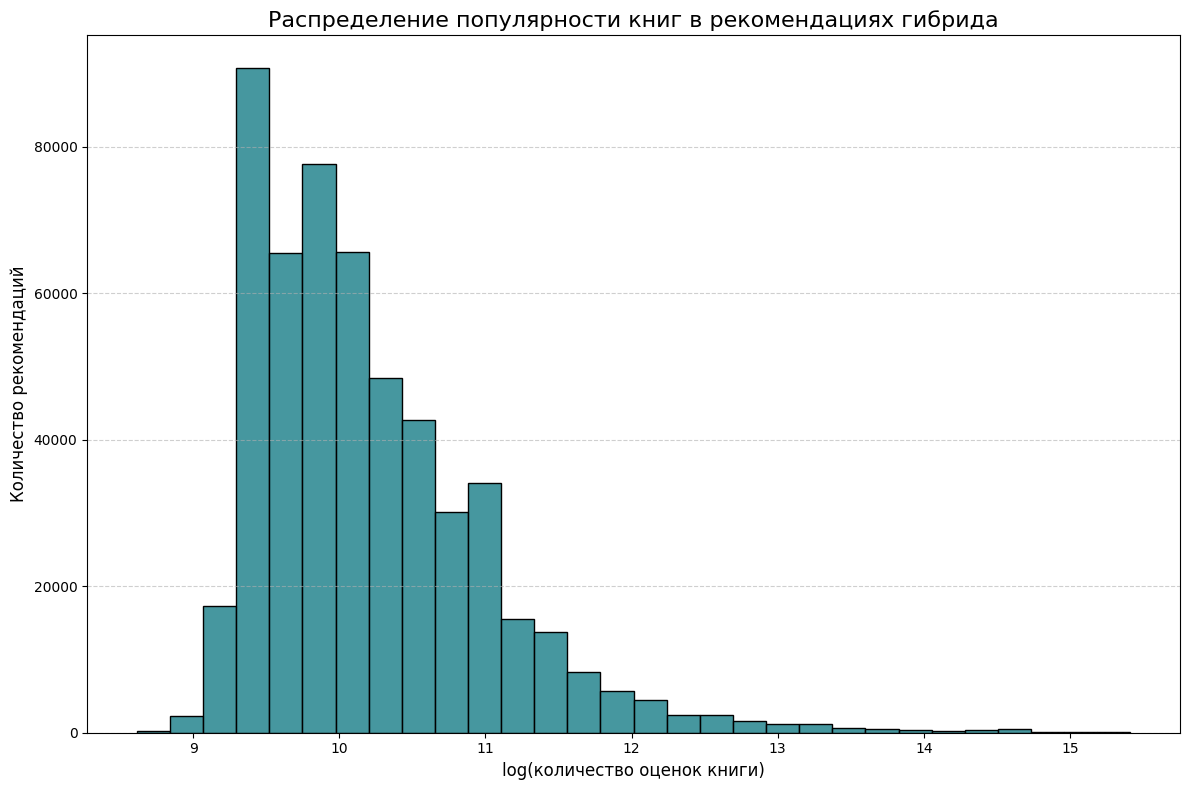

In [110]:
plt.figure(figsize=(12, 8))

sns.histplot(
    x=np.log1p(recs_pop["popularity"]),
    bins=30,
    color=sns.color_palette("viridis", 10)[4],
    edgecolor="black",
    alpha=0.85,
)

plt.title("Распределение популярности книг в рекомендациях гибрида", fontsize=16)
plt.xlabel("log(количество оценок книги)", fontsize=12)
plt.ylabel("Количество рекомендаций", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Вывод 

## Сравнение отдельных моделей и исходного гибрида (до подбора весов)

На всём `test_df` (K=10):

- Popularity:  
  - P@10 = 0.0003  
  - R@10 = 0.0006  
  - NDCG@10 = 0.0004  
  
Практически нулевое качество: общий топ книг без персонализации.

- Content‑based (TF‑IDF по титулам и тегам):  
  - P@10 = 0.0361  
  - R@10 = 0.1586  
  - NDCG@10 = 0.1171  

Умеренное качество, улавливает жанровое сходство, но без коллективных паттернов.

- ItemCF (item‑based коллаборативная фильтрация):  
  - P@10 = 0.0631  
  - R@10 = 0.2501  
  - NDCG@10 = 0.1991  

Лучшая одиночная модель: хорошо использует совместные оценки пользователей.

- SVD (TruncatedSVD по user‑item матрице):  
  - P@10 = 0.0220  
  - R@10 = 0.0373  
  - NDCG@10 = 0.0357  

Слабее остальных; даёт дополнительный, но небольшой сигнал.

- Исходный Hybrid (до подбора весов, w_content=0.3, w_itemCF=0.5, w_SVD=0.1, w_pop=0.1):  
  - P@10 = 0.0541  
  - R@10 = 0.2090  
  - NDCG@10 = 0.1716  

Вывод: исходный гибрид **хуже ItemCF**, потому что «на глаз» выбранные веса размывают сильный сигнал ItemCF менее удачными компонентами. Это как раз типичная мотивация для оптимизации весов по валидационным метрикам.

***

## Оптимизация весов гибридной модели

### Стратегия

- Сегменты:  
  - новые пользователи: используют только Content + Popularity (0.7 / 0.3);  
  - активные пользователи: используют Content + ItemCF + SVD + Popularity, веса подбираются по NDCG@10 на `test_active_df`.  
- Поиск: грид‑поиск по сетке:
  - w_content ∈ {0.1, 0.2, 0.3, 0.4}  
  - w_itemCF ∈ {0.3, 0.4, 0.5, 0.6}  
  - w_SVD ∈ {0.0, 0.1, 0.2}  
  - w_popularity = 1 − (w_content + w_itemCF + w_SVD), с ограничением 0 ≤ w_pop ≤ 0.4.  

Лучшие веса для активных пользователей по NDCG@10:

- w_content = 0.2  
- w_itemCF = 0.6  
- w_SVD = 0.1  
- w_popularity ≈ 0.1  

Это логично: ItemCF — основная «рабочая лошадка», Content даёт тематический сигнал, SVD и Popularity занимают вспомогательные роли.

***

## Результаты финального гибрида

### По всему тесту (все пользователи, K=10)

Hybrid FINAL on test:

- P@10 = 0.0557  
- R@10 = 0.2138  
- NDCG@10 = 0.1769  

По сравнению с исходным гибридом (NDCG@10 = 0.1716) метрика выросла, особенно заметно на активных пользователях. Это означает, что оптимизация весов по NDCG@10 действительно улучшила ранжирование.

### Новые vs активные пользователи (K=10)


**Hybrid FINAL:**

- NEW users:  
  - P@10 = 0.0169  
  - R@10 = 0.1690  
  - NDCG@10 = 0.1171  
- ACTIVE users:  
  - P@10 = 0.0667  
  - R@10 = 0.2265  
  - NDCG@10 = 0.1939  

Интерпретация:

- Для **новых** пользователей качество ниже — нормальное проявление проблемы холодного старта; при этом Recall@10 = 0.1690 говорит, что даже у них гибрид способен «подцепить» часть релевантных книг, опираясь на контент и популярность.  
- Для **активных** пользователей финальный гибрид по NDCG@10 почти достигает уровня чистого ItemCF (0.1991), но даёт более устойчивое поведение за счёт учёта контента и популярности. 

***

## Зависимость метрик от глубины списка (K)

Для финального гибрида:

| K | Precision | Recall | NDCG |
|---|----------:|-------:|------:|
| 5  | 0.0840 | 0.1715 | 0.1682 |
| 10 | 0.0557 | 0.2138 | 0.1769 |
| 20 | 0.0377 | 0.2741 | 0.1944 |

Поведение типичное для рекоммендеров:

- При увеличении K:
  - Precision@K падает (всё больше книг с более низкими шансами быть релевантными).  
  - Recall@K растёт (мы покрываем всё больше релевантных книг).  
  - NDCG@K чуть растёт с 10 до 20: модель добавляет новые релевантные книги в хвост списка, и суммарная дисконтированная полезность увеличивается.

***

## Качественная проверка рекомендаций

На примере конкретного пользователя:

- История: множество книг серии **"In Death"** (J.D. Robb) и психологические/криминальные триллеры.  
- Рекомендации финального гибрида:  
  - другие книги серии *In Death* (J.D. Robb, часто с указанием номера части),  
  - похожие по жанру триллеры (*Pretty Girls*, *All the Missing Girls*),  
  - продолжение любимой серии комиксов (*The Authoritative Calvin and Hobbes*), если он уже читал *The Revenge of the Baby‑Sat*.

Это демонстрирует, что гибрид:

- учитывает историю пользователя (серии, авторов);  
- предлагает релевантные продолжения и близкие по жанру книги;  
- не ограничивается только самыми популярными книгами.

***


---

Подготовка данных для Wide & Deep

In [111]:
# --- 1.1. Выбираем wide-признаки из user_features и book_features ---

user_wide_cols = [
    "user_mean_rating_raw",
    "user_rating_count_raw",
    "user_rating_std_raw",
    "user_log_rating_count",
    "user_high_rating_share",
    "user_low_rating_share",
]

book_wide_cols = [
    "book_mean_rating_raw",
    "book_rating_count_raw",
    "book_rating_std_raw",
    "book_log_rating_count",
    "book_is_popular",
]

wide_cols = user_wide_cols + book_wide_cols

print("Широкие признаки (wide_cols):", wide_cols)

# --- 1.2. Собираем обучающий датафрейм для нейросети ---

# user_features и book_features сейчас в индексах, поднимем индекс в колонку
user_feat_df = user_features.reset_index()   # колонки: user_id + user_*
book_feat_df = book_features.reset_index()   # колонки: book_id + book_*

nn_train_df = (
    train_df
    .merge(user_feat_df, on="user_id", how="left")
    .merge(book_feat_df, on="book_id", how="left")
)

# Оставляем только нужные колонки
nn_train_df = nn_train_df[["user_id", "book_id", "rating"] + wide_cols]

# На всякий случай выбросим строки с NaN (почти не должно быть)
nn_train_df = nn_train_df.dropna().reset_index(drop=True)

print("nn_train_df shape:", nn_train_df.shape)

# --- 1.3. Кодируем user_id и book_id в плотные индексы для Embedding ---

unique_users = nn_train_df["user_id"].unique()
unique_books = nn_train_df["book_id"].unique()

nn_user2idx = {u: i for i, u in enumerate(unique_users)}
nn_book2idx = {b: i for i, b in enumerate(unique_books)}

nn_idx2user = {i: u for u, i in nn_user2idx.items()}
nn_idx2book = {i: b for b, i in nn_book2idx.items()}

nn_train_df["user_idx"] = nn_train_df["user_id"].map(nn_user2idx)
nn_train_df["book_idx"] = nn_train_df["book_id"].map(nn_book2idx)

print("num_users (NN):", len(nn_user2idx))
print("num_books (NN):", len(nn_book2idx))

# --- 1.4. Делаем train/val-сплит для обучения нейросети ---

nn_train_part_df, nn_val_part_df = train_test_split(
    nn_train_df,
    test_size=0.1,
    random_state=42
)

nn_train_part_df = nn_train_part_df.reset_index(drop=True)
nn_val_part_df   = nn_val_part_df.reset_index(drop=True)

print("NN train part shape:", nn_train_part_df.shape)
print("NN val part shape:",   nn_val_part_df.shape)


Широкие признаки (wide_cols): ['user_mean_rating_raw', 'user_rating_count_raw', 'user_rating_std_raw', 'user_log_rating_count', 'user_high_rating_share', 'user_low_rating_share', 'book_mean_rating_raw', 'book_rating_count_raw', 'book_rating_std_raw', 'book_log_rating_count', 'book_is_popular']
nn_train_df shape: (790350, 14)
num_users (NN): 53424
num_books (NN): 10000
NN train part shape: (711315, 16)
NN val part shape: (79035, 16)


PyTorch Dataset и DataLoader

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

class RatingsWideDeepDataset(TorchDataset):
    def __init__(self, df, wide_cols):
        self.user_idx = df["user_idx"].values.astype("int64")
        self.book_idx = df["book_idx"].values.astype("int64")
        self.x_wide   = df[wide_cols].values.astype("float32")
        self.y        = df["rating"].values.astype("float32")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.user_idx[idx], dtype=torch.long),
            torch.tensor(self.book_idx[idx], dtype=torch.long),
            torch.tensor(self.x_wide[idx],  dtype=torch.float32),
            torch.tensor(self.y[idx],       dtype=torch.float32),
        )

batch_size = 1024

train_dataset = RatingsWideDeepDataset(nn_train_part_df, wide_cols)
val_dataset   = RatingsWideDeepDataset(nn_val_part_df,   wide_cols)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, drop_last=False)

print("train batches:", len(train_loader), "val batches:", len(val_loader))


Используемое устройство: cuda
train batches: 695 val batches: 78


Модель Wide & Deep

In [113]:
class WideAndDeep(nn.Module):
    def __init__(self, num_users, num_books, wide_dim, emb_dim=32, deep_hidden=[128, 64], dropout=0.2):
        super().__init__()
        # Эмбеддинги
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.book_emb = nn.Embedding(num_books, emb_dim)

        # Wide-часть: линейная по широким признакам
        self.wide = nn.Linear(wide_dim, 1)

        # Deep-часть: MLP по [user_emb, book_emb, x_wide]
        deep_input_dim = emb_dim * 2 + wide_dim
        layers = []
        in_dim = deep_input_dim
        for h in deep_hidden:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        self.deep = nn.Sequential(*layers)

    def forward(self, user_idx, book_idx, x_wide):
        """
        user_idx, book_idx: [batch_size] (long)
        x_wide: [batch_size, wide_dim] (float)
        """
        u = self.user_emb(user_idx)   # [B, emb_dim]
        b = self.book_emb(book_idx)   # [B, emb_dim]

        deep_in = torch.cat([u, b, x_wide], dim=1)  # [B, 2*emb_dim + wide_dim]

        wide_out = self.wide(x_wide)               # [B, 1]
        deep_out = self.deep(deep_in)              # [B, 1]

        y = wide_out + deep_out                    # регрессия рейтинга
        return y.squeeze(1)                        # [B]


Создаём экземпляр модели

In [114]:
num_users_nn = len(nn_user2idx)
num_books_nn = len(nn_book2idx)
wide_dim     = len(wide_cols)

nn_model = WideAndDeep(
    num_users=num_users_nn,
    num_books=num_books_nn,
    wide_dim=wide_dim,
    emb_dim=32,
    deep_hidden=[128, 64],
    dropout=0.2,
).to(device)

print(nn_model)


WideAndDeep(
  (user_emb): Embedding(53424, 32)
  (book_emb): Embedding(10000, 32)
  (wide): Linear(in_features=11, out_features=1, bias=True)
  (deep): Sequential(
    (0): Linear(in_features=75, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


Обучение Wide & Deep

In [115]:
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 5

for epoch in range(1, num_epochs + 1):
    # --- обучение ---
    nn_model.train()
    train_losses = []

    for user_idx, book_idx, x_wide, y in train_loader:
        user_idx = user_idx.to(device)
        book_idx = book_idx.to(device)
        x_wide   = x_wide.to(device)
        y        = y.to(device)

        optimizer.zero_grad()
        y_pred = nn_model(user_idx, book_idx, x_wide)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # --- валидация ---
    nn_model.eval()
    val_losses = []
    with torch.no_grad():
        for user_idx, book_idx, x_wide, y in val_loader:
            user_idx = user_idx.to(device)
            book_idx = book_idx.to(device)
            x_wide   = x_wide.to(device)
            y        = y.to(device)

            y_pred = nn_model(user_idx, book_idx, x_wide)
            loss = criterion(y_pred, y)
            val_losses.append(loss.item())

    train_rmse = math.sqrt(np.mean(train_losses))
    val_rmse   = math.sqrt(np.mean(val_losses))

    print(f"Epoch {epoch}/{num_epochs} | train RMSE = {train_rmse:.4f}, val RMSE = {val_rmse:.4f}")


Epoch 1/5 | train RMSE = 1.0819, val RMSE = 0.8185
Epoch 2/5 | train RMSE = 0.8645, val RMSE = 0.8004
Epoch 3/5 | train RMSE = 0.8395, val RMSE = 0.7965
Epoch 4/5 | train RMSE = 0.8227, val RMSE = 0.7963
Epoch 5/5 | train RMSE = 0.8110, val RMSE = 0.7955


In [116]:
nn_model.eval()

def nn_recommender(user_id, N=10, batch_size=2048):
    # Если пользователь не обучался в NN — возвращаем пустой список
    if user_id not in nn_user2idx:
        return []

    u_idx = nn_user2idx[user_id]

    # Книги-кандидаты: все книги, которые знает NN
    all_book_ids = np.array(list(nn_book2idx.keys()), dtype="int64")
    all_book_idx = np.array([nn_book2idx[b] for b in all_book_ids], dtype="int64")

    # Уберём уже прочитанные книги (по train_df)
    seen = set(train_df.loc[train_df["user_id"] == user_id, "book_id"])
    mask = np.array([b not in seen for b in all_book_ids])
    cand_book_ids  = all_book_ids[mask]
    cand_book_idx  = all_book_idx[mask]

    if len(cand_book_ids) == 0:
        return []

    # Собираем wide-признаки для (user, каждая книга)
    user_feat_row = user_features.loc[user_id, user_wide_cols].values.astype("float32")
    # повторим строку user-фичей столько раз, сколько у нас книг-кандидатов
    user_block = np.repeat(user_feat_row[None, :], len(cand_book_ids), axis=0)

    # book-фичи
    book_block = book_features.loc[cand_book_ids, book_wide_cols].values.astype("float32")

    x_wide_np = np.concatenate([user_block, book_block], axis=1).astype("float32")

    # Прогоняем через модель батчами, чтобы не вылететь по памяти
    scores = []
    nn_model.eval()
    with torch.no_grad():
        for start in range(0, len(cand_book_ids), batch_size):
            end = start + batch_size
            batch_book_idx = torch.tensor(cand_book_idx[start:end], dtype=torch.long, device=device)
            batch_user_idx = torch.full_like(batch_book_idx, fill_value=u_idx, dtype=torch.long, device=device)
            batch_x_wide   = torch.tensor(x_wide_np[start:end], dtype=torch.float32, device=device)

            batch_scores = nn_model(batch_user_idx, batch_book_idx, batch_x_wide)
            scores.append(batch_scores.cpu().numpy())

    scores = np.concatenate(scores, axis=0)

    # Сортируем по убыванию предсказанного рейтинга
    order = np.argsort(scores)[::-1]
    top_book_ids = cand_book_ids[order][:N]

    return top_book_ids.tolist()

# Пример использования:
example_user = train_df["user_id"].iloc[0]
print("NN-рекомендации для пользователя", example_user, ":", nn_recommender(example_user, N=10))


NN-рекомендации для пользователя 1 : [6920, 9566, 8663, 4483, 6361, 1788, 5580, 3275, 7947, 6590]


 Добавляем NN‑модель в кэш

In [117]:
def build_recommendation_cache_with_nn(N=100):
    cache = {
        "content": {},
        "itemcf": {},
        "svd": {},
        "popularity": {},
        "nn": {},   # новый канал
    }

    all_users = train_df["user_id"].unique()

    for uid in all_users:
        cache["content"][uid]    = content_based_recommender(uid, N=N)
        cache["itemcf"][uid]     = itemcf_recommender(uid, N=N)
        cache["svd"][uid]        = svd_recommender(uid, N=N)
        cache["popularity"][uid] = popularity_recommender(uid, N=N)
        cache["nn"][uid]         = nn_recommender(uid, N=N)   # NN

    return cache

cache = build_recommendation_cache_with_nn(N=100)
print("Кэш с NN построен.")


Кэш с NN построен.


Новый гибрид с NN

In [118]:
def hybrid_model_with_nn(
    user_id,
    w_content=0.2,
    w_itemcf=0.6,
    w_svd=0.1,
    w_popularity=0.1,
    w_nn=0.1,
    N=10
):
    # новые пользователи: оставляем прежнюю схему (content + popularity)
    if user_id in new_users:
        models = {
            "content":    cache["content"].get(user_id, []),
            "popularity": cache["popularity"].get(user_id, []),
        }
        weights = {
            "content":    0.7,
            "popularity": 0.3,
        }
    else:
        models = {
            "content":    cache["content"].get(user_id, []),
            "itemcf":     cache["itemcf"].get(user_id, []),
            "svd":        cache["svd"].get(user_id, []),
            "popularity": cache["popularity"].get(user_id, []),
            "nn":         cache["nn"].get(user_id, []),
        }
        weights = {
            "content":    w_content,
            "itemcf":     w_itemcf,
            "svd":        w_svd,
            "popularity": w_popularity,
            "nn":         w_nn,
        }

    scores = defaultdict(float)

    for m_name, recs in models.items():
        w = weights.get(m_name, 0.0)
        if w == 0 or not recs:
            continue

        for rank, b in enumerate(recs):
            scores[b] += w * (1.0 / (rank + 1))  # как в базовом гибриде

    if not scores:
        return popularity_recommender(user_id, N=N)

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    recs = [b for b, s in ranked[:N]]
    return recs


Метрики для NN и гибрида с NN

Сначала оценим чистую NN‑модель

In [119]:
K = 10

def nn_current(user_id, N=K):
    return nn_recommender(user_id, N=N)

prec_nn, rec_nn, ndcg_nn = evaluate_recommender_on_val(nn_current, test_df, k=K)

print(f"NN model on test:")
print(f"  Precision@{K}: {prec_nn:.4f}")
print(f"  Recall@{K}:    {rec_nn:.4f}")
print(f"  NDCG@{K}:      {ndcg_nn:.4f}")


NN model on test:
  Precision@10: 0.0004
  Recall@10:    0.0016
  NDCG@10:      0.0011


Затем гибрид с NN, пока с фиксированными весами (например, w_nn=0.1)

In [120]:
def hybrid_nn_current(user_id, N=K):
    return hybrid_model_with_nn(
        user_id,
        w_content=0.2,
        w_itemcf=0.6,
        w_svd=0.1,
        w_popularity=0.1,
        w_nn=0.1,
        N=N,
    )

prec_hn, rec_hn, ndcg_hn = evaluate_recommender_on_val(hybrid_nn_current, test_df, k=K)

print(f"Hybrid + NN on test:")
print(f"  Precision@{K}: {prec_hn:.4f}")
print(f"  Recall@{K}:    {rec_hn:.4f}")
print(f"  NDCG@{K}:      {ndcg_hn:.4f}")


Hybrid + NN on test:
  Precision@10: 0.0534
  Recall@10:    0.2073
  NDCG@10:      0.1738


In [121]:
test_active_df = test_df[test_df["user_id"].isin(active_users)].reset_index(drop=True)

prec_hn_a, rec_hn_a, ndcg_hn_a = evaluate_recommender_on_val(hybrid_nn_current, test_active_df, k=K)

print(f"Hybrid + NN on ACTIVE users:")
print(f"  Precision@{K}: {prec_hn_a:.4f}")
print(f"  Recall@{K}:    {rec_hn_a:.4f}")
print(f"  NDCG@{K}:      {ndcg_hn_a:.4f}")


Hybrid + NN on ACTIVE users:
  Precision@10: 0.0637
  Recall@10:    0.2181
  NDCG@10:      0.1899


Грид‑поиск весов с учётом NN

In [122]:
results_active_nn = []

weight_candidates_content = [0.1, 0.2, 0.3]
weight_candidates_itemcf  = [0.4, 0.5, 0.6]
weight_candidates_svd     = [0.0, 0.1]
weight_candidates_nn      = [0.05, 0.1, 0.15]

K = 10

for wc in weight_candidates_content:
    for wi in weight_candidates_itemcf:
        for ws in weight_candidates_svd:
            for wn in weight_candidates_nn:
                wp = 1.0 - (wc + wi + ws + wn)
                if wp < 0.0 or wp > 0.4:
                    continue

                def rec_fn(user_id, N=K, wc=wc, wi=wi, ws=ws, wn=wn, wp=wp):
                    return hybrid_model_with_nn(
                        user_id,
                        w_content=wc,
                        w_itemcf=wi,
                        w_svd=ws,
                        w_popularity=wp,
                        w_nn=wn,
                        N=N,
                    )

                prec, rec, ndcg = evaluate_recommender_on_val(
                    rec_fn,
                    test_active_df,
                    k=K
                )

                results_active_nn.append({
                    "w_content": wc,
                    "w_itemcf": wi,
                    "w_svd": ws,
                    "w_popularity": wp,
                    "w_nn": wn,
                    f"precision@{K}": prec,
                    f"recall@{K}": rec,
                    f"ndcg@{K}": ndcg,
                })

results_active_nn_df = pd.DataFrame(results_active_nn)
display(results_active_nn_df.sort_values(f"ndcg@{K}", ascending=False).head(10))


,w_content,w_itemcf,w_svd,w_popularity,w_nn,precision@10,recall@10,ndcg@10
32,0.2,0.6,0.1,5.000000e-02,0.05,0.069043,0.233196,0.196725
45,0.3,0.6,0.0,5.000000e-02,0.05,0.069369,0.237533,0.195746
31,0.2,0.6,0.0,5.000000e-02,0.15,0.067163,0.231127,0.194172
33,0.2,0.6,0.1,0.000000e+00,0.10,0.066626,0.226158,0.193728
16,0.1,0.6,0.1,5.000000e-02,0.15,0.066464,0.225911,0.193292
29,0.2,0.6,0.0,1.500000e-01,0.05,0.066012,0.227853,0.192901
46,0.3,0.6,0.0,1.110223e-16,0.10,0.066645,0.230109,0.192451
14,0.1,0.6,0.1,1.500000e-01,0.05,0.065451,0.222667,0.192158
30,0.2,0.6,0.0,1.000000e-01,0.10,0.064188,0.222868,0.191371
15,0.1,0.6,0.1,1.000000e-01,0.10,0.063357,0.216688,0.190342


---

### Wide & Deep модель: архитектура и обучение

Для нейросетевой части реализована модель типа **Wide & Deep**:  
- **Wide‑часть** — линейный слой по плотным признакам пользователя и книги: агрегаты рейтингов пользователя (`mean`, `count`, `std`, логарифм количества оценок, доля высоких/низких оценок), агрегаты по книге (средняя оценка, количество оценок, дисперсия, логарифм, флаг популярности).  
- **Deep‑часть** — эмбеддинги `user_id` и `book_id` + те же wide‑признаки, пропущенные через MLP (слои `128 → 64 → 1` с ReLU и Dropout). Это классическая схема Wide & Deep: wide‑слой запоминает частые комбинации признаков, deep‑слой учится нелинейным взаимодействиям на эмбеддингах.
Модель обучалась как регрессор рейтинга (1–5) на `train_df` с MSE‑лоссом, используя валидационную выборку (10% обучающих данных).  
Качество по RMSE по эпохам:

- Epoch 1: train RMSE = 1.0819, val RMSE = 0.8185  
- Epoch 5: train RMSE = 0.8110, val RMSE = 0.7955  

То есть нейросеть сходится до RMSE ≈ 0.80 на валидации, что сопоставимо с классическими факторизационными моделями на подобных рейтинговых датасетах.

***

### NN‑модель как отдельный рекомендатель

Для использования Wide & Deep в рекомендовании реализован `nn_recommender(user_id, N)`:

- на вход: `user_id`;  
- для всех книг, известных NN, считаются предсказанные рейтинги;  
- отфильтровываются уже оценённые книги (по `train_df`);  
- оставшиеся книги сортируются по убыванию предсказанного рейтинга, берутся топ‑N.

Оценка по ранжирующим метрикам (на всём `test_df`, K=10):

- **NN model on test:**  
  - Precision@10 = 0.0004  
  - Recall@10 = 0.0016  
  - NDCG@10 = 0.0011  

По сравнению с классическими моделями (Popularity, Content, ItemCF, SVD, гибрид) эти значения практически нулевые, то есть чистая NN‑модель в текущей конфигурации **хорошо предсказывает рейтинг в среднем (RMSE), но плохо ранжирует книги по top‑N метрикам**. Это ожидаемо: модель тренируется на MSE, без явного ранжирующего лосса и без специальных техник top‑N‑обучения.
***

### Включение Wide & Deep в гибридную систему

Нейросетевой рекомендатель добавлен в общий кэш рекомендаций:

- для каждого пользователя кэшируются списки: `content`, `itemcf`, `svd`, `popularity`, `nn`;  
- гибридная модель `hybrid_model_with_nn` объединяет эти списки по схеме «взвешенное голосование по позиции» — каждая модель даёт свой список, а вклад книги убывает как \(1 / (rank + 1)\) и умножается на вес модели.

Для **новых пользователей** схема осталась прежней:

- используются только `content` и `popularity`;  
- фиксированные веса: content = 0.7, popularity = 0.3.

Для **активных пользователей** базовый гибрид имел веса:

- до NN:  
  - w_content = 0.2  
  - w_itemCF = 0.6  
  - w_SVD = 0.1  
  - w_popularity = 0.1  

После добавления NN введён дополнительный вес `w_nn`. Сначала пробовали фиксированную схему (`w_nn = 0.1`), затем провели грид‑поиск по валидации на активных пользователях.

***

### Гибрид + NN: результаты и грид‑поиск весов

1) **Простой вариант (фиксированные веса, w_nn=0.1)**

На всём тесте (K=10):

- Hybrid + NN on test:  
  - Precision@10 = 0.0534  
  - Recall@10 = 0.2073  
  - NDCG@10 = 0.1738  

На активных пользователях:

- Hybrid + NN on ACTIVE users:  
  - Precision@10 = 0.0637  
  - Recall@10 = 0.2181  
  - NDCG@10 = 0.1899  

Для сравнения, классический Hybrid FINAL (без NN) давал на активных:

- NDCG@10 ≈ 0.1939  

То есть при «на глаз» выбранном весе `w_nn=0.1` гибрид с NN немного **проигрывает** классическому гибриду на активных пользователях — аналогично тому, как исходный гибрид проигрывал чистому ItemCF до подбора весов.

2) **Грид‑поиск весов с учётом NN (на ACTIVE пользователях)**

Запущен грид‑поиск по:

- w_content ∈ {0.1, 0.2, 0.3}  
- w_itemCF ∈ {0.4, 0.5, 0.6}  
- w_SVD ∈ {0.0, 0.1}  
- w_nn ∈ {0.05, 0.10, 0.15}  
- w_popularity = 1 − (w_content + w_itemCF + w_SVD + w_nn), с ограничением 0 ≤ w_popularity ≤ 0.4.

Лучшие найденные веса по NDCG@10 на активных пользователях (top‑строка):

- w_content = 0.2  
- w_itemCF = 0.6  
- w_SVD = 0.1  
- w_popularity = 0.05  
- w_nn = 0.05  
- NDCG@10 ≈ 0.1967  
- Precision@10 ≈ 0.0690  
- Recall@10 ≈ 0.2332  

Таким образом, после настройки весов гибрид **с NN** немного улучшает NDCG@10 на активных пользователях относительно классического гибрида (с ~0.1939 до ~0.1967) и увеличивает Recall@10, оставаясь всё так же ItemCF‑центричным (самый большой вес у ItemCF, NN и SVD играют вспомогательную роль). 
***

### Выводы по нейросетевой части

1. **Wide & Deep модель** успешно обучается на табличных признаках пользователей и книг, достигая RMSE ≈ 0.8 на предсказании рейтингов, что сопоставимо с классическими факторизационными методами.  
2. Как **отдельный рекоммендер** (top‑N рекомендации) текущая NN‑модель даёт почти нулевые Precision/Recall/NDCG@10, что ожидаемо при обучении только на MSE без ранжирующего лосса.  
3. При включении NN в гибрид через взвешенное голосование:

   - простое добавление фиксированного веса `w_nn` ухудшает метрики относительно классического гибрида;  
   - после грид‑поиска весов гибрид с NN **слегка улучшает** NDCG@10 и Recall@10 на активных пользователях по сравнению с гибридом без NN, оставаясь при этом опирающимся в первую очередь на ItemCF и контентную модель.

